# Image recreation experiments analysis

Experiment 1 (drawings) and Experiment 2 (interface) complete analysis

## Notepad setup

In [1]:
## import libraries

import os
import random
import zlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage.feature import canny
from pathlib import Path

In [2]:
## define filepaths

project_path =  Path().resolve().parent
tables_path = os.path.join(project_path, "015_tables")
raw_data_path = os.path.join(project_path, "005_cleaned_data")
raw_data_path_targets = os.path.join(project_path, "007_targets")
viz_path = os.path.join(project_path, "020_visualizations")

print(project_path)

E:\Research2\VizEx_analysis_replication


In [5]:
## helper functions

def save_fig(fig, name: str, dpi: int = 300):
    os.makedirs(viz_path, exist_ok=True)
    path = os.path.join(viz_path, f"{name}.png")
    fig.savefig(path, dpi=dpi, bbox_inches="tight", pad_inches=0.02)
    print(f"[saved] {path}")
    return path

In [15]:
## convert from old to new data convention

import os
from pathlib import Path

import numpy as np
import pandas as pd

# Paths (as specified)
project_path = Path().resolve().parent
tables_path = os.path.join(project_path, "015_tables")
raw_data_path = os.path.join(project_path, "005_cleaned_data")
raw_data_path_targets = os.path.join(project_path, "007_targets")
viz_path = os.path.join(project_path, "020_visualizations")

# I/O
in_fp = os.path.join(tables_path, "cleaned_file_index.csv")
out_fp = os.path.join(tables_path, "vizex_trials.csv")

df = pd.read_csv(in_fp)

# Mapping: condition_code (integer) -> condition_hz
HZ_MAP = {
    1: 2.5,
    2: 5,
    3: 10,
    4: 15,
    5: 20,
    6: 40,
    7: 80,
}

def _parse_int_or_na(x):
    """Return int if x is an integer-like value, else pd.NA."""
    if pd.isna(x):
        return pd.NA
    s = str(x).strip()
    # Accept "1", "1.0", etc. but reject non-integers like "1.5"
    try:
        f = float(s)
    except ValueError:
        return pd.NA
    if np.isfinite(f) and float(f).is_integer():
        return int(f)
    return pd.NA

def _format_hz(hz):
    """Format Hz without trailing .0 (e.g., 5 not 5.0), keep 2.5 as 2.5."""
    if pd.isna(hz):
        return pd.NA
    hz_f = float(hz)
    if hz_f.is_integer():
        return str(int(hz_f))
    return str(hz_f)

# --- Build output columns ---
out = pd.DataFrame(index=df.index)

# participant_code is final_participant
out["participant_code"] = df.get("final_participant", pd.Series([pd.NA] * len(df)))

# condition_code is trialT (keep as original text)
out["condition_code"] = df.get("trialT", pd.Series([pd.NA] * len(df)))

# stimulus_type: LIGHT if condition_code is an integer, otherwise IMAGE
trialT_int = out["condition_code"].apply(_parse_int_or_na)
out["stimulus_type"] = np.where(trialT_int.isna(), "IMAGE", "LIGHT")

# condition_hz: map integers 1..7, else null
out["condition_hz"] = trialT_int.map(HZ_MAP).astype("Float64")

# condition_name: same as condition_hz + " Hz" if valid
hz_str = out["condition_hz"].apply(_format_hz)
out["condition_name"] = np.where(hz_str.isna(), pd.NA, hz_str + " Hz")

# condition_type:
# - always VALIDATION if stimulus_type is IMAGE
# - otherwise EXPERIMENTAL for numbers 1..6, CONTROL for 7
def _condition_type(stimulus_type, trialT_int_val):
    if stimulus_type == "IMAGE":
        return "VALIDATION"
    if pd.isna(trialT_int_val):
        return pd.NA
    if 1 <= int(trialT_int_val) <= 6:
        return "EXPERIMENTAL"
    if int(trialT_int_val) == 7:
        return "CONTROL"
    return pd.NA

out["condition_type"] = [
    _condition_type(st, ti) for st, ti in zip(out["stimulus_type"], trialT_int)
]

# trialn is trialN
out["trialn"] = df.get("trialN", pd.Series([pd.NA] * len(df)))

# png_filename is clean_filename
out["png_filename"] = df.get("clean_filename", pd.Series([pd.NA] * len(df)))

# Ensure column order exactly as requested
out = out[
    [
        "participant_code",
        "condition_code",
        "condition_name",
        "condition_hz",
        "condition_type",
        "stimulus_type",
        "trialn",
        "png_filename",
    ]
]

out = out[~out["condition_code"].astype(str).str.strip().isin(["9", "POSTQ"])].copy()

# Keep only rows where png_filename ends with "cropped.png"
out = out[
    out["png_filename"].astype(str).str.strip().str.endswith("cropped.png")
].copy()

# Force trialn to be integer (set invalid values to NA, then drop if needed)
out["trialn"] = pd.to_numeric(out["trialn"], errors="coerce").astype("Int64")

out.to_csv(out_fp, index=False)
print(f"Saved: {out_fp} ({len(out):,} rows)")



Saved: E:\Research2\VizEx_analysis_replication\015_tables\vizex_trials.csv (3,156 rows)


In [16]:
# --- Generate target table (A00–A14, B00–B14, C00–C14) ---

rows = []

for prefix in ["A", "B", "C"]:
    for i in range(15):  # 00–14
        code = f"{prefix}{i:02d}"
        rows.append({
            "condition_code": code,
            "condition_name": f"Image {code}",
            "png_filename": f"{code}.png",
        })

targs = pd.DataFrame(rows)

targs_fp = os.path.join(tables_path, "targs.csv")
targs.to_csv(targs_fp, index=False)

print(f"Saved: {targs_fp} ({len(targs)} rows)")

Saved: E:\Research2\VizEx_analysis_replication\015_tables\targs.csv (45 rows)


## Load data

In [17]:
# -------------------------------
# Load CSVs and register datasets
# (VizEx single-experiment version)
# -------------------------------

# Paths to CSV files
vizex_csv_path = os.path.join(tables_path, "vizex_trials.csv")
vizex_targets_csv_path = os.path.join(tables_path, "targs.csv")

# Read CSVs
df_vizex = pd.read_csv(vizex_csv_path)
df_vizex_targets = pd.read_csv(vizex_targets_csv_path)

# Create working copies (this is where we’ll add focal points + feature columns)
df_vizex_features = df_vizex.copy(deep=True)
df_vizex_targets_features = df_vizex_targets.copy(deep=True)

# Quick checks
display(df_vizex.head())
display(df_vizex_targets.head())

# Image roots (edit these if your on-disk folder names differ)
raw_data_path_vizex = raw_data_path                 # participant images
raw_data_path_targets_vizex = raw_data_path_targets # target images

image_paths = {
    "vizex": raw_data_path_vizex,
    "vizex_targets": raw_data_path_targets_vizex,
}

# Dataset registry
# - dataset_id: selects dataframe + image path
# - domain_key: selects preprocessing conventions (now just 'vizex')
datasets = {
    "vizex": {
        "name": "VizEx",
        "domain_key": "vizex",
        "df_raw": df_vizex,
        "df": df_vizex_features,          # working df
        "image_path": image_paths["vizex"],
    },
    "vizex_targets": {
        "name": "VizEx Targets",
        "domain_key": "vizex",            # IMPORTANT: preprocess like vizex
        "df_raw": df_vizex_targets,
        "df": df_vizex_targets_features,
        "image_path": image_paths["vizex_targets"],
    },
}

# Sanity checks: required columns
REQUIRED_COLS = ["png_filename"]
for k, ds in datasets.items():
    missing = [c for c in REQUIRED_COLS if c not in ds["df"].columns]
    if missing:
        raise KeyError(f"Dataset '{k}' is missing required columns in df: {missing}")

# Sanity checks: image_path exists
for k, ds in datasets.items():
    if not os.path.isdir(ds["image_path"]):
        print(f"WARNING: image_path not found for '{k}': {ds['image_path']}")


participant_code condition_code condition_name  condition_hz condition_type  \
0          TKB3728              7          80 Hz          80.0        CONTROL   
1          TKB3728              7          80 Hz          80.0        CONTROL   
2          ABU7735              7          80 Hz          80.0        CONTROL   
3          ABU7735              7          80 Hz          80.0        CONTROL   
4          BCE0029              7          80 Hz          80.0        CONTROL   

  stimulus_type  trialn                                       png_filename  
0         LIGHT       2  saveTime_2510171012__sessionTime_202510170920_...  
1         LIGHT       2  saveTime_2510171012__sessionTime_202510170920_...  
2         LIGHT       2  saveTime_2510171013__sessionTime_202510170920_...  
3         LIGHT       2  saveTime_2510171013__sessionTime_202510170920_...  
4         LIGHT       2  saveTime_2510171013__sessionTime_202510170920_...

condition_code condition_name png_filename
0            A00      Image A00      A00.png
1            A01      Image A01      A01.png
2            A02      Image A02      A02.png
3            A03      Image A03      A03.png
4            A04      Image A04      A04.png

VizEx — random image check


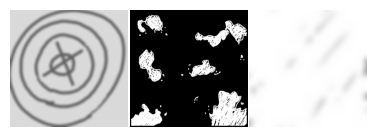

VizEx Targets — random image check


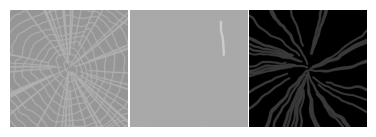

In [18]:
# -------------------------------
# Dataset image loading sanity check
# -------------------------------

def load_grayscale_image(path):
    img = Image.open(path).convert("L")
    return np.asarray(img, dtype=np.float32) / 255.0


def show_random_images_per_dataset(
    datasets: dict,
    n_images: int = 3,
    figsize_per_image: float = 1.2,
    seed: int | None = None,
):
    """
    Display n_images random images per dataset as a quick loading sanity check.

    - Images are shown small and compact.
    - No titles are baked into figures.
    - Dataset name is printed before each figure.
    - Figures are NOT saved.
    """

    if seed is not None:
        random.seed(seed)

    for dataset_key, ds in datasets.items():
        df = ds["df"]
        img_path = ds["image_path"]
        name = ds.get("name", dataset_key)

        if "png_filename" not in df.columns:
            print(f"[{name}] missing 'png_filename' column, skipping.")
            continue

        filenames = df["png_filename"].dropna().astype(str).tolist()
        if len(filenames) == 0:
            print(f"[{name}] no images found, skipping.")
            continue

        sample = random.sample(filenames, min(n_images, len(filenames)))

        print(f"{name} — random image check")

        fig, axes = plt.subplots(
            1,
            len(sample),
            figsize=(figsize_per_image * len(sample), figsize_per_image),
        )

        if len(sample) == 1:
            axes = [axes]

        for ax, fname in zip(axes, sample):
            full_path = os.path.join(img_path, fname)
            try:
                img = load_grayscale_image(full_path)
                ax.imshow(img, cmap="gray", vmin=0, vmax=1)
                ax.axis("off")
            except FileNotFoundError:
                ax.axis("off")
                print(f"  missing file: {full_path}")

        plt.tight_layout(pad=0.1)
        plt.show()


# Run sanity check
show_random_images_per_dataset(datasets)


## Focal point definition

In [19]:
# -------------------------------
# Focal points (deprecated): force all to centre (0,0)
# -------------------------------
for ds in datasets.values():
    for df_key in ["df_raw", "df"]:
        d = ds[df_key]
        d["focal_x_norm"] = 0.0
        d["focal_y_norm"] = 0.0


## Preprocessing

VizEx | domain=vizex | file=saveTime_2510171555__sessionTime_202510171420__participant_IJM4327__trialN_10__trialT_3__fileType_uncropped.png


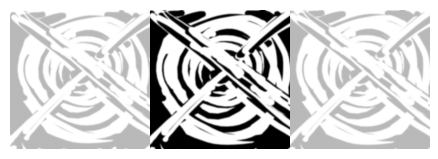

VizEx Targets | domain=vizex | file=B13.png


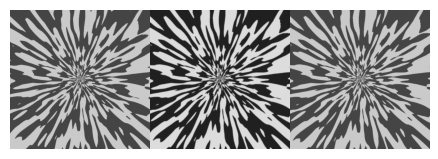

In [26]:
# -------------------------------
# Preprocessing (VizEx: single domain) + visualization
# -------------------------------

# Fixed (global) preprocessing constants — single pipeline for all images
VIZEX_EDGE_BLUR_SIGMA = 1.0  # "Gaussian blur radius of 1"


def _to_float_grayscale(image_array: np.ndarray) -> np.ndarray:
    """Ensure grayscale float32 image; if RGB, convert with luminance weights."""
    arr = image_array
    if isinstance(arr, np.ndarray) and arr.ndim == 3:
        rgb = arr[..., :3].astype(np.float32)
        arr = 0.2126 * rgb[..., 0] + 0.7152 * rgb[..., 1] + 0.0722 * rgb[..., 2]
    return arr.astype(np.float32, copy=False)


def _minmax01(arr: np.ndarray) -> np.ndarray:
    arr = arr.astype(np.float32, copy=False)
    mn = float(np.nanmin(arr))
    mx = float(np.nanmax(arr))
    return (arr - mn) / (mx - mn + 1e-8)


# --- Global crop setting (in case you need to adjust) ---
VIZEX_CROP_PIXELS = 12


def _crop_alpha_border(arr: np.ndarray, crop_pixels: int = VIZEX_CROP_PIXELS) -> np.ndarray:
    """
    Crop fixed border (e.g. invisible alpha padding) from all sides.
    Assumes border width is constant and known.
    """
    if crop_pixels <= 0:
        return arr

    h, w = arr.shape[:2]
    if 2 * crop_pixels >= h or 2 * crop_pixels >= w:
        raise ValueError(f"crop_pixels={crop_pixels} too large for image shape {arr.shape}")

    return arr[crop_pixels:h - crop_pixels, crop_pixels:w - crop_pixels]



def preprocess_vizex_for_edges(image_array: np.ndarray) -> np.ndarray:
    """
    VizEx, edge-based features:
      1) grayscale float32
      2) crop alpha border
      3) contrast normalisation (min-max)
      4) Gaussian blur (sigma=1)
    """
    arr = _to_float_grayscale(image_array)
    arr = _crop_alpha_border(arr)

    norm = _minmax01(arr)
    blurred = gaussian_filter(norm, sigma=VIZEX_EDGE_BLUR_SIGMA)
    return blurred


def preprocess_vizex_for_intensity(image_array: np.ndarray) -> np.ndarray:
    """
    VizEx, intensity-based features:
      1) grayscale float32
      2) crop alpha border
    No blur. No normalisation.
    """
    arr = _to_float_grayscale(image_array)
    arr = _crop_alpha_border(arr)

    return arr.astype(np.float32, copy=False)


def preprocess_image(image_array: np.ndarray, domain_key: str, preprocess_kind: str) -> np.ndarray:
    """
    preprocess_kind:
      - "edges"     for detail + orientation
      - "intensity" for brightness (and other intensity measures)
    domain_key:
      - "vizex" only (kept for compatibility with the existing pipeline)
    """
    dk = str(domain_key).lower()
    pk = str(preprocess_kind).lower()

    if dk != "vizex":
        raise ValueError(f"Unknown domain_key: {domain_key} (expected 'vizex')")

    if pk == "edges":
        return preprocess_vizex_for_edges(image_array)
    if pk == "intensity":
        return preprocess_vizex_for_intensity(image_array)

    raise ValueError(f"Unknown preprocess_kind: {preprocess_kind}")


# --- Visualization helper (unsaved) ---

def show_random_preprocessing_check(
    dataset_key: str,
    datasets: dict,
    *,
    seed: int | None = None,
    image_idx=None,
    figsize=(4.2, 1.6),
):
    """
    Unsaved visual check:
      - prints dataset + filename
      - shows original, edges-preprocess, intensity-preprocess (no titles in the figure)
    """
    ds = datasets[dataset_key]
    df = ds["df"]
    img_root = ds["image_path"]
    domain_key = ds["domain_key"]
    name = ds.get("name", dataset_key)

    if "png_filename" not in df.columns:
        raise KeyError(f"{dataset_key} missing 'png_filename'")

    if image_idx is not None:
        if image_idx not in df.index:
            raise KeyError(f"image_idx {image_idx} not in df.index for {dataset_key}")
        row = df.loc[image_idx]
    else:
        row = df.sample(1, random_state=int(seed) if seed is not None else None).iloc[0]

    fname = str(row["png_filename"])
    path = os.path.join(img_root, fname)

    img = load_grayscale_image(path)  # expected float32 in [0,1]
    pre_edges = preprocess_image(img, domain_key=domain_key, preprocess_kind="edges")
    pre_intensity = preprocess_image(img, domain_key=domain_key, preprocess_kind="intensity")

    print(f"{name} | domain={domain_key} | file={fname}")

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    axes[0].imshow(img, cmap="gray", vmin=0, vmax=1)
    axes[1].imshow(pre_edges, cmap="gray", vmin=0, vmax=1)
    axes[2].imshow(pre_intensity, cmap="gray", vmin=0, vmax=1)
    for ax in axes:
        ax.axis("off")
    plt.tight_layout(pad=0.05)
    plt.show()


# Run check on one random image per dataset (unsaved)
for k in datasets.keys():
    show_random_preprocessing_check(k, datasets)


## Detail Level feature

This feature measures the edge density across an image to quantify its detail level.

This feature definition is combined with a series of blocks of code which visualise this function and calulate it for experimental analyses; these functions are then applied to the other feature calculation functions defined later in this notebook.

### Define the detail level feature calculation function

In [21]:
# -------------------------------
# Detail feature (LoG) as a heatmap + scalar reducer (uniform feature signature)
# -------------------------------

from scipy.ndimage import gaussian_laplace  # ensure imported

DETAIL_LOG_SIGMA = 1.0  # fixed globally


def detail_map_log(
    preprocessed_image: np.ndarray,
    *,
    focal_x_norm: float = 0.0,
    focal_y_norm: float = 0.0,
) -> np.ndarray:
    """
    Level-of-detail heatmap via |LoG|.

    Uniform feature signature:
      - accepts focal_x_norm / focal_y_norm (ignored for detail)
      - input MUST already be preprocessed for edge features
      - returns float32 heatmap (H×W), nonnegative
      - no scaling/clipping applied here
    """
    _ = (focal_x_norm, focal_y_norm)  # unused, but keeps signature uniform

    if preprocessed_image is None or (isinstance(preprocessed_image, np.ndarray) and preprocessed_image.size == 0):
        return np.zeros((1, 1), dtype=np.float32)

    proc = preprocessed_image.astype(np.float32, copy=False)
    log_edges = np.abs(gaussian_laplace(proc, sigma=DETAIL_LOG_SIGMA)).astype(np.float32, copy=False)
    return log_edges


def heatmap_to_value(heatmap: np.ndarray) -> float:
    """
    Convert a heatmap to its final scalar value.
    Currently: mean over all finite pixels.
    Kept as a function for future adjustments.
    """
    if heatmap is None or heatmap.size == 0:
        return 0.0
    vals = heatmap[np.isfinite(heatmap)]
    if vals.size == 0:
        return 0.0
    return float(np.mean(vals))


### Test the detail level function on indivual images

VizEx trials | detail | condition=1 | file=saveTime_2510241628__sessionTime_202510241500__participant_CMB3661__trialN_9__trialT_1__fileType_uncropped.png | focal=(0.000,0.000) | mean_raw=0.000488


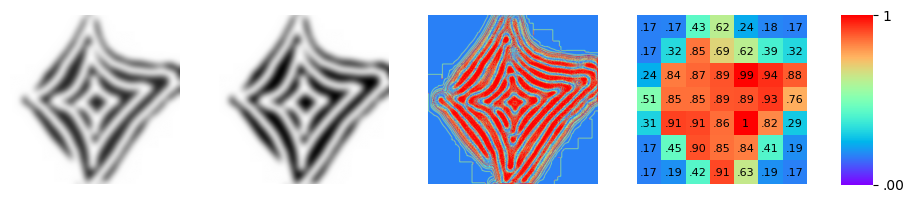

VizEx trials | detail | condition=1 | file=saveTime_2510241831__sessionTime_202510241700__participant_QSJ9035__trialN_10__trialT_1__fileType_uncropped.png | focal=(0.000,0.000) | mean_raw=0.008019


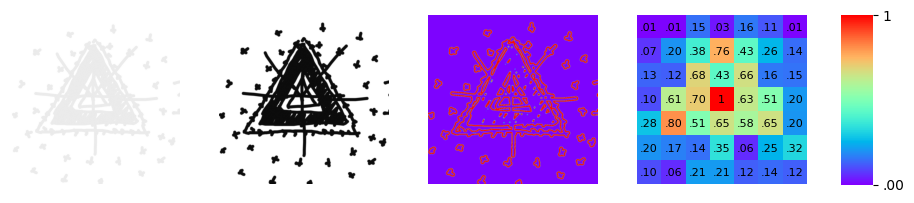

VizEx targets | detail | condition=B01 | file=B01.png | focal=(0.000,0.000) | mean_raw=0.008467


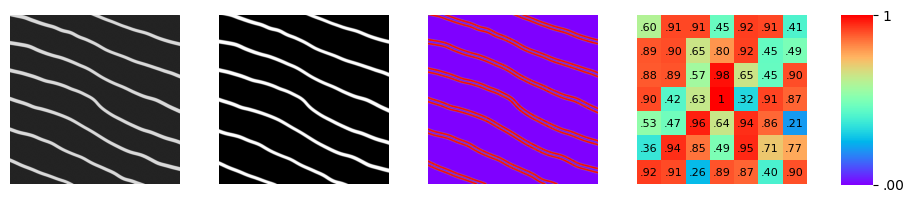

In [43]:
# -------------------------------
# Generic single-image feature breakdown (unsaved) + test on detail
# VizEx: no dataset_key plumbing (works on one df + one image root)
# -------------------------------

def bin_mean_map(map2d: np.ndarray, bins: int = 7) -> np.ndarray:
    """Bin a 2D map into (bins×bins) by mean within each cell."""
    h, w = map2d.shape
    out = np.zeros((bins, bins), dtype=np.float32)
    for i in range(bins):
        y0 = int(i * h / bins)
        y1 = int((i + 1) * h / bins)
        for j in range(bins):
            x0 = int(j * w / bins)
            x1 = int((j + 1) * w / bins)
            patch = map2d[y0:y1, x0:x1]
            vals = patch[np.isfinite(patch)]
            out[i, j] = float(np.mean(vals)) if vals.size else 0.0
    return out


def rescale_by_max(map2d: np.ndarray) -> tuple[np.ndarray, float]:
    """Map -> (map01, vmax_raw) where map01 = map / vmax_raw and vmax_raw = max(finite(map))."""
    vals = map2d[np.isfinite(map2d)]
    if vals.size == 0:
        return np.zeros_like(map2d, dtype=np.float32), 0.0
    vmax = float(np.max(vals))
    if not np.isfinite(vmax) or vmax <= 0:
        return np.zeros_like(map2d, dtype=np.float32), vmax
    return (map2d / vmax).astype(np.float32, copy=False), vmax


def apply_norm_scale_scalar(val: float, norm_scale: float | None) -> float | None:
    if norm_scale is None:
        return None
    if not np.isfinite(val):
        return np.nan
    return float(np.clip(val * float(norm_scale), 0.0, 1.0))


def _format_cell(v: float) -> str:
    """Two decimals, no leading zero; '1' if ~1."""
    if np.isfinite(v) and abs(v - 1.0) < 1e-6:
        return "1"
    s = f"{v:.2f}"
    return s[1:] if s.startswith("0") else s


def get_image_row(df: pd.DataFrame, *, seed: int | None = None, image_idx=None) -> pd.Series:
    """Select a row by idx, else by seeded sample, else random sample."""
    if image_idx is not None:
        if image_idx not in df.index:
            raise KeyError(f"image_idx {image_idx} not in df.index")
        return df.loc[image_idx]
    return df.sample(1, random_state=int(seed) if seed is not None else None).iloc[0]


def compute_feature_maps_for_row(
    row: pd.Series,
    *,
    img_root: str,
    preprocess_kind: str,
    feature_map_fn,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Returns: (orig_img, preprocessed_img, feature_map_raw)."""
    fname = str(row["png_filename"])
    img_path = os.path.join(img_root, fname)

    orig = load_grayscale_image(img_path)
    pre = preprocess_image(orig, domain_key="vizex", preprocess_kind=preprocess_kind)

    fx = float(row.get("focal_x_norm", 0.0))
    fy = float(row.get("focal_y_norm", 0.0))
    fmap = feature_map_fn(pre, focal_x_norm=fx, focal_y_norm=fy)
    return orig, pre, fmap


def show_single_image_feature_breakdown(
    df: pd.DataFrame,
    *,
    img_root: str,
    feature_name: str,
    feature_map_fn,
    preprocess_kind: str,
    bins: int = 7,
    norm_scale: float | None = None,
    display_mode: str = "per_image",   # "per_image" or "normalized"
    seed: int | None = None,
    image_idx=None,
    figsize=(11.2, 2.2),
    cbar_width_ratio: float = 0.18,
    label: str = "VizEx",
):
    """
    Unsaved figure:
      1) original
      2) preprocessed
      3) raw heatmap (scaled for display)
      4) binned heatmap with printed values (scaled for display)
      5) vertical colorbar
    """
    row = get_image_row(df, seed=seed, image_idx=image_idx)

    orig, pre, fmap_raw = compute_feature_maps_for_row(
        row,
        img_root=img_root,
        preprocess_kind=preprocess_kind,
        feature_map_fn=feature_map_fn,
    )

    # Scalars
    scalar_raw = heatmap_to_value(fmap_raw)
    scalar_norm = apply_norm_scale_scalar(scalar_raw, norm_scale)

    # Binning based on RAW map
    bmap_raw = bin_mean_map(fmap_raw, bins=bins)

    # Choose display scaling
    display_mode = str(display_mode).lower()
    if display_mode == "normalized":
        if norm_scale is None:
            raise ValueError("display_mode='normalized' requires norm_scale.")
        fmap_disp = (fmap_raw.astype(np.float32) * float(norm_scale)).clip(0.0, 1.0)
        bmap_disp = (bmap_raw.astype(np.float32) * float(norm_scale)).clip(0.0, 1.0)
        vmin, vmax = 0.0, 1.0
    elif display_mode == "per_image":
        bmap_disp, vmax_bin_raw = rescale_by_max(bmap_raw)
        fmap_disp = (fmap_raw / vmax_bin_raw).astype(np.float32, copy=False) if vmax_bin_raw > 0 else np.zeros_like(fmap_raw, dtype=np.float32)
        vmin, vmax = 0.0, 1.0
    else:
        raise ValueError("display_mode must be 'per_image' or 'normalized'.")

    # Text output (no titles in figure)
    fname = str(row.get("png_filename", ""))
    cond = row.get("condition_code", "?")
    fx = float(row.get("focal_x_norm", 0.0))
    fy = float(row.get("focal_y_norm", 0.0))

    if scalar_norm is None:
        print(f"{label} | {feature_name} | condition={cond} | file={fname} | focal=({fx:.3f},{fy:.3f}) | mean_raw={scalar_raw:.6f}")
    else:
        print(f"{label} | {feature_name} | condition={cond} | file={fname} | focal=({fx:.3f},{fy:.3f}) | mean_raw={scalar_raw:.6f} | mean_norm={scalar_norm:.6f} | norm_scale={float(norm_scale):.6g}")

    # Plot (unsaved)
    fig, axes = plt.subplots(
        1, 5,
        figsize=figsize,
        gridspec_kw={"width_ratios": [1, 1, 1, 1, cbar_width_ratio]},
    )

    axes[0].imshow(orig, cmap="gray", vmin=0, vmax=1)
    axes[1].imshow(pre, cmap="gray", vmin=0, vmax=1)
    axes[2].imshow(fmap_disp, cmap="rainbow", vmin=vmin, vmax=vmax)
    im_binned = axes[3].imshow(bmap_disp, cmap="rainbow", vmin=vmin, vmax=vmax, interpolation="nearest", origin="upper")

    for i in range(bins):
        for j in range(bins):
            axes[3].text(j, i, _format_cell(float(bmap_disp[i, j])), ha="center", va="center", fontsize=8)

    for ax in axes[:4]:
        ax.axis("off")

    cax = axes[4]
    cbar = fig.colorbar(im_binned, cax=cax, orientation="vertical")
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels([_format_cell(0.0), "1"])
    cbar.outline.set_visible(False)
    plt.show()


def run_feature_breakdown_diagnostics(
    df_trials: pd.DataFrame,
    df_targets: pd.DataFrame,
    *,
    img_root_trials: str,
    img_root_targets: str,
    feature_name: str,
    feature_map_fn,
    preprocess_kind: str,
    bins: int = 7,
    norm_scale_trials: float | None = None,
    norm_scale_targets: float | None = None,
    display_mode: str = "per_image",
):
    """Run on: 2 random trials + 1 random target."""
    for _ in range(2):
        show_single_image_feature_breakdown(
            df_trials,
            img_root=img_root_trials,
            feature_name=feature_name,
            feature_map_fn=feature_map_fn,
            preprocess_kind=preprocess_kind,
            bins=bins,
            norm_scale=norm_scale_trials,
            display_mode=display_mode,
            label="VizEx trials",
        )

    show_single_image_feature_breakdown(
        df_targets,
        img_root=img_root_targets,
        feature_name=feature_name,
        feature_map_fn=feature_map_fn,
        preprocess_kind=preprocess_kind,
        bins=bins,
        norm_scale=norm_scale_targets,
        display_mode=display_mode,
        label="VizEx targets",
    )


# --- Test on DETAIL feature ---

# assumes you already have:
#   df_vizex_features (or equivalent trials df)
#   df_vizex_targets_features (targets df)
#   raw_data_path_vizex (trial images root)
#   raw_data_path_targets_vizex (target images root)

run_feature_breakdown_diagnostics(
    df_vizex_features,
    df_vizex_targets_features,
    img_root_trials=raw_data_path_vizex,
    img_root_targets=raw_data_path_targets_vizex,
    feature_name="detail",
    feature_map_fn=detail_map_log,
    preprocess_kind="edges",
    bins=7,
    display_mode="per_image",
)


### Calculate the detail level feature across the dataset

In [29]:
# -------------------------------
# Apply a feature to an entire dataset with optional normalization
# -------------------------------


def value_from_map_mean(map_arr: np.ndarray) -> float:
    return float(np.mean(map_arr[np.isfinite(map_arr)])) if map_arr.size else 0.0


def value_from_map_rms(map_arr: np.ndarray) -> float:
    """
    For contrast_map_rms_sq: return sqrt(mean(square deviations)) = std-like RMS contrast.
    """
    m = float(np.mean(map_arr[np.isfinite(map_arr)])) if map_arr.size else 0.0
    return float(np.sqrt(max(m, 0.0)))

def compute_feature_means_raw_for_dataset(
    dataset_key: str,
    datasets: dict,
    *,
    feature_map_fn,
    preprocess_kind: str,
    out_col: str,
    value_from_map_fn=value_from_map_mean,
) -> np.ndarray:
    """
    For each row in datasets[dataset_key]['df']:
      - load image
      - preprocess (based on ds['domain_key'] + preprocess_kind)
      - compute feature map (feature_map_fn)
      - convert map -> scalar via value_from_map_fn
      - store scalar into df[f"{out_col}_raw"]

    Returns:
      raw_vals (np.ndarray) of shape (n_rows,) containing the computed raw scalars (finite only).
    """
    ds = datasets[dataset_key]
    df = ds["df"]
    img_root = ds["image_path"]
    domain_key = ds["domain_key"]

    raw_col = f"{out_col}_raw"
    raw_values = np.full(len(df), np.nan, dtype=np.float32)

    for i, (idx, row) in enumerate(df.iterrows()):
        fname = row.get("png_filename", None)
        if not isinstance(fname, str) or not fname:
            continue

        img_path = os.path.join(img_root, fname)
        if not os.path.exists(img_path):
            continue

        # Load -> [0,1] float32
        img = load_grayscale_image(img_path)

        # Preprocess once (global; no per-patch re-preprocess)
        pre = preprocess_image(img, domain_key=domain_key, preprocess_kind=preprocess_kind)

        # Focal point (always passed; most features ignore)
        fx = float(row.get("focal_x_norm", 0.0))
        fy = float(row.get("focal_y_norm", 0.0))

        fmap = feature_map_fn(pre, focal_x_norm=fx, focal_y_norm=fy)

        raw_val = value_from_map_fn(fmap)
        raw_values[i] = raw_val

    # Write back aligned to df order
    df[raw_col] = raw_values

    # Return finite values for quantile computation
    finite = raw_values[np.isfinite(raw_values)]
    return finite.astype(np.float32, copy=False)

def value_from_map_mean(map_arr: np.ndarray) -> float:
    """
    Default scalar: mean of the map (used by detail, brightness, orientation).
    """
    if map_arr is None or map_arr.size == 0:
        return 0.0
    vals = map_arr[np.isfinite(map_arr)]
    return float(vals.mean()) if vals.size else 0.0


def value_from_map_rms(map_arr: np.ndarray) -> float:
    """
    RMS value from a squared-deviation map.
    Intended for contrast_map_rms_sq:
      contrast = sqrt(mean((I - mean(I))^2))
    """
    if map_arr is None or map_arr.size == 0:
        return 0.0
    vals = map_arr[np.isfinite(map_arr)]
    if vals.size == 0:
        return 0.0
    return float(np.sqrt(max(vals.mean(), 0.0)))

norm_quantile = 0.95  # global quantile value

def apply_feature_to_dataset(
    dataset_key: str,
    datasets: dict,
    *,
    feature_key: str,
    feature_map_fn,
    preprocess_kind: str,
    out_col: str | None = None,
    norm_scale: float | None = None,
    value_from_map_fn=value_from_map_mean,
) -> float:
    """
    Compute per-image feature values, normalize with a linear multiplier,
    and store results in ds['df'].

    Normalization:
      - If norm_scale provided: use it as a linear multiplier.
      - Else: compute norm_scale so that Q(norm_quantile) of RAW values maps to 1.
        i.e., norm_scale = 1 / quantile(raw_values, norm_quantile)

    Stores:
      - '{out_col}_raw' : raw per-image values
      - '{out_col}'     : normalized per-image values = raw * norm_scale
        (NO clipping — linear transform only)

    Returns:
      norm_scale (float)
    """
    ds = datasets[dataset_key]
    df = ds["df"]

    if out_col is None:
        out_col = feature_key

    # ---- 1) Compute raw values and store
    raw_vals = compute_feature_means_raw_for_dataset(
        dataset_key,
        datasets,
        feature_map_fn=feature_map_fn,
        preprocess_kind=preprocess_kind,
        out_col=out_col,
        value_from_map_fn=value_from_map_fn,
    )

    if raw_vals.size == 0:
        if f"{out_col}" not in df.columns:
            df[out_col] = np.nan
        return 1.0 if norm_scale is None else float(norm_scale)

    # ---- 2) Determine normalization scale
    if norm_scale is None:
        q = float(np.nanquantile(raw_vals, norm_quantile))
        if not np.isfinite(q) or q <= 0:
            norm_scale = 1.0
        else:
            norm_scale = 1.0 / q
        print(
            f"[{dataset_key} | {feature_key}] "
            f"computed norm_scale (Q{norm_quantile:.2f}→1): {norm_scale:.6g}"
        )
    else:
        norm_scale = float(norm_scale)
        print(
            f"[{dataset_key} | {feature_key}] "
            f"using provided norm_scale: {norm_scale:.6g}"
        )

    # ---- 3) Apply linear normalization (NO CLIPPING)
    raw_col = f"{out_col}_raw"
    df[out_col] = df[raw_col].astype(np.float32) * norm_scale

    return norm_scale



In [ ]:
# -------------------------------
# Apply to DETAIL: compute scale on main datasets, reuse on targets
# -------------------------------

# Drawings: compute scale on drawings, apply to drawings_targets
vizex_detail_normscale = apply_feature_to_dataset(
    dataset_key="vizex",
    datasets=datasets,
    feature_key="detail",
    feature_map_fn=detail_map_log,
    preprocess_kind="edges",
    out_col="detail",
    norm_scale=None,          # compute from drawings
)

_ = apply_feature_to_dataset(
    dataset_key="vizex_targets",
    datasets=datasets,
    feature_key="detail",
    feature_map_fn=detail_map_log,
    preprocess_kind="edges",
    out_col="detail",
    norm_scale=vizex_detail_normscale,  # reuse
)


# Quick sanity: show a few rows with new cols
display(datasets["vizex"]["df"][["png_filename", "condition_code", "detail_raw", "detail"]].head())
display(datasets["vizex_targets"]["df"][["png_filename", "condition_code", "detail_raw", "detail"]].head())

[vizex | detail] computed norm_scale (Q0.95→1): 45.6421
[vizex_targets | detail] using provided norm_scale: 45.6421


png_filename condition_code  \
0  saveTime_2510171012__sessionTime_202510170920_...              7   
1  saveTime_2510171012__sessionTime_202510170920_...              7   
2  saveTime_2510171013__sessionTime_202510170920_...              7   
3  saveTime_2510171013__sessionTime_202510170920_...              7   
4  saveTime_2510171013__sessionTime_202510170920_...              7   

   detail_raw    detail  
0    0.000837  0.038183  
1    0.000872  0.039785  
2    0.003865  0.176419  
3    0.003953  0.180417  
4    0.000246  0.011246

png_filename condition_code  detail_raw    detail
0      A00.png            A00    0.007142  0.325984
1      A01.png            A01    0.010301  0.470164
2      A02.png            A02    0.005755  0.262681
3      A03.png            A03    0.010703  0.488512
4      A04.png            A04    0.018649  0.851198

### Visualise the detail level feature using normalised and precomputed feature data

In [46]:
# -------------------------------
# Feature distribution histogram (normalized values)
# -------------------------------

def plot_feature_distribution(
    dataset_key: str,
    datasets: dict,
    *,
    feature_name: str,
    feature_col: str | None = None,
    norm_scale: float | None = None,
    bins: int = 40,
    figsize=(6, 3),
):
    """
    Plot a frequency histogram of a NORMALISED feature distribution
    and print summary statistics.

    Assumptions:
      - The feature has already been computed and stored in ds['df'][feature_col]
      - Values are expected to be in [0,1]

    Parameters
    ----------
    dataset_key : str
        Key into datasets dict.
    feature_name : str
        Human-readable feature name (for printout only).
    feature_col : str or None
        Column name in df. Defaults to feature_name.
    norm_scale : float or None
        Linear normalization scale used to produce this feature.
        Printed for record-keeping only.
    """
    ds = datasets[dataset_key]
    df = ds["df"]
    name = ds.get("name", dataset_key)

    if feature_col is None:
        feature_col = feature_name

    if feature_col not in df.columns:
        raise KeyError(f"Column '{feature_col}' not found in dataset '{dataset_key}'")

    vals = df[feature_col].astype(float).dropna().values
    if vals.size == 0:
        print(f"[{name} | {feature_name}] no valid values, skipping.")
        return

    # Summary stats
    vmin = float(np.min(vals))
    vmax = float(np.max(vals))
    vmean = float(np.mean(vals))
    vsd = float(np.std(vals, ddof=1)) if vals.size > 1 else 0.0

    # Print summary (text only, no figure titles)
    if norm_scale is None:
        print(
            f"{name} | {feature_name} | "
            f"min={vmin:.4f}, mean={vmean:.4f}, sd={vsd:.4f}, max={vmax:.4f}"
        )
    else:
        print(
            f"{name} | {feature_name} | "
            f"min={vmin:.4f}, mean={vmean:.4f}, sd={vsd:.4f}, max={vmax:.4f} | "
            f"norm_scale={float(norm_scale):.6g}"
        )

    # Plot histogram (normalized 0–1)
    fig, ax = plt.subplots(figsize=figsize)
    xmin = float(np.min(vals))
    xmax = float(np.max(vals))

    ax.hist(vals, bins=bins, edgecolor="black")
    ax.set_xlim(xmin, xmax)
    ax.set_yticks([])
    ax.set_xlabel(f"{feature_name} (normalised)")
    ax.set_ylabel("Frequency")

    plt.show()


VizEx | detail | min=0.0000, mean=0.2394, sd=0.3326, max=2.0480 | norm_scale=45.6421


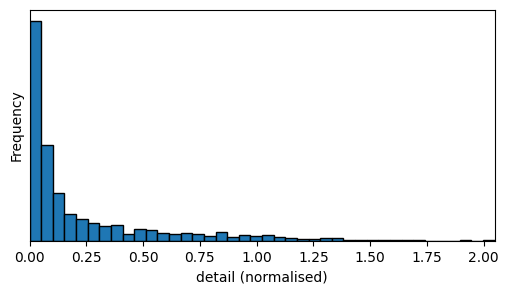

In [47]:
# -------------------------------
# Apply to DETAIL feature (main datasets only)
# -------------------------------

plot_feature_distribution(
    dataset_key="vizex",
    datasets=datasets,
    feature_name="detail",
    feature_col="detail",
    norm_scale=vizex_detail_normscale,
    bins=40,
)



VizEx trials | detail | condition=3 | file=saveTime_2510171340__sessionTime_202510171240__participant_CPX5604__trialN_4__trialT_3__fileType_cropped.png | focal=(0.000,0.000) | mean_raw=0.001924 | mean_norm=0.087804 | norm_scale=45.6421


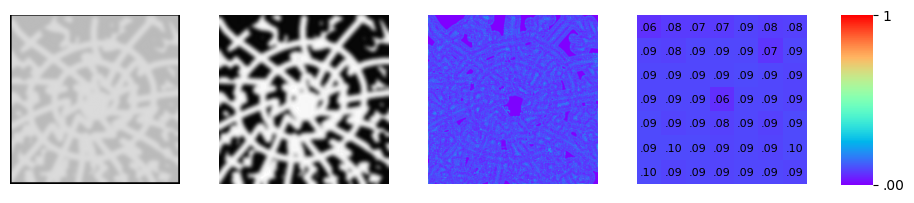

VizEx trials | detail | condition=2 | file=saveTime_2510171734__sessionTime_202510171600__participant_WBJ1554__trialN_9__trialT_2__fileType_uncropped.png | focal=(0.000,0.000) | mean_raw=0.022135 | mean_norm=1.000000 | norm_scale=45.6421


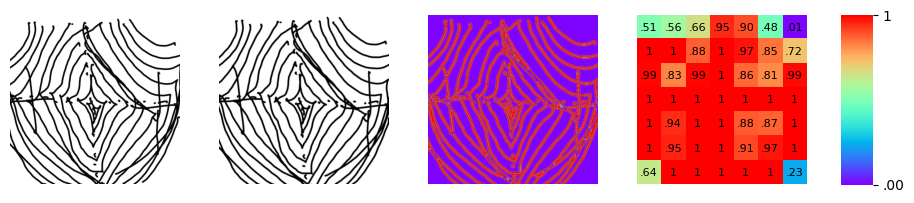

VizEx targets | detail | condition=A12 | file=A12.png | focal=(0.000,0.000) | mean_raw=0.003293 | mean_norm=0.150283 | norm_scale=45.6421


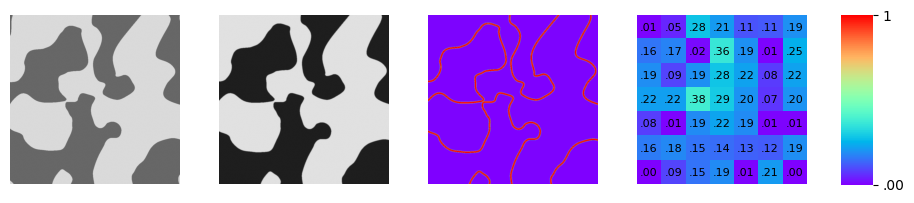

In [50]:
norm_scales = {
    "vizex": vizex_detail_normscale,
    "vizex_targets": vizex_detail_normscale,
}

run_feature_breakdown_diagnostics(
    df_vizex_features,
    df_vizex_targets_features,
    img_root_trials=raw_data_path_vizex,
    img_root_targets=raw_data_path_targets_vizex,
    feature_name="detail",
    feature_map_fn=detail_map_log,
    preprocess_kind="edges",
    bins=7,
    norm_scale_trials=norm_scales["vizex"],
    norm_scale_targets=norm_scales["vizex_targets"],
    display_mode="normalized",
)

In [51]:
# -------------------------------
# Spectrum visualization across a dataset (low→high; uses precomputed scalar values, recomputes maps)
# -------------------------------

# -------------------------------
# Spectrum selection with controlled randomisation (seeded)
# -------------------------------

def select_spectrum_rows_by_value(
    df: pd.DataFrame,
    value_col: str,
    n: int,
    *,
    target_min: float = 0.0,
    target_max: float = 1.0,
    jitter_frac: float = 0.15,
    k_candidates: int = 12,
    seed: int | None = None,
) -> pd.DataFrame:
    """
    Select n rows whose precomputed values cover targets from target_min→target_max, left→right,
    with optional randomisation:

    - For each target, we jitter the target within +/- jitter_frac * step
    - Then choose randomly among the k_candidates nearest rows (excluding used rows)

    If seed is None, results vary each call. If seed is set, selection is reproducible.
    """
    dfv = df[[value_col]].copy()
    dfv[value_col] = pd.to_numeric(dfv[value_col], errors="coerce")
    dfv = dfv[np.isfinite(dfv[value_col].values)]
    if dfv.empty:
        return df.iloc[0:0]

    vals = dfv[value_col].values.astype(float)
    idxs = dfv.index.values

    rng = np.random.default_rng(seed)

    targets = np.linspace(target_min, target_max, n) if n > 1 else np.array([(target_min + target_max) / 2.0])
    step = (target_max - target_min) / (n - 1) if n > 1 else 0.0

    used = set()
    chosen = []

    for t in targets:
        # jitter target
        if step > 0 and jitter_frac > 0:
            t_j = float(t + rng.uniform(-jitter_frac * step, jitter_frac * step))
        else:
            t_j = float(t)

        diffs = np.abs(vals - t_j)

        # mask out used
        if used:
            mask_used = np.isin(idxs, list(used))
            diffs = diffs.copy()
            diffs[mask_used] = np.inf

        # take k nearest candidates then pick one randomly
        k = int(min(max(1, k_candidates), np.isfinite(diffs).sum()))
        nearest = np.argpartition(diffs, kth=k-1)[:k]
        nearest = nearest[np.isfinite(diffs[nearest])]
        if nearest.size == 0:
            continue
        pick_pos = int(rng.integers(0, nearest.size))
        best = int(nearest[pick_pos])

        best_idx = idxs[best]
        used.add(best_idx)
        chosen.append(best_idx)

    return df.loc[chosen]

def show_feature_spectrum(
    dataset_key: str,
    datasets: dict,
    *,
    feature_name: str,
    feature_map_fn,
    preprocess_kind: str,
    value_col: str | None = None,      # column containing NORMALISED per-image scalar values (already scaled)
    norm_scale: float,                  # dataset-specific norm_scale used to create value_col; used for map scaling
    n: int = 9,
    bins: int = 7,
    figsize_per_col: float = 1.5,
    cmap: str = "rainbow",
    seed: int | None = None,            # only used if you later add tie-breaking randomness
    color_scale: tuple[float, float] | None = None,  # (vmin, vmax) override for heatmap color scale
):
    """
    Unsaved spectrum:
      columns = selected images spanning targets from 0→1 (left→right)
      rows:
        0) original
        1) preprocessed
        2) heatmap (NORMALISED via norm_scale; not clipped)
        3) 7x7 binned heatmap (NORMALISED via norm_scale; numbers printed)

    - Uses precomputed scalar values to pick images.
    - Recomputes maps from images for visualization.
    - Color scale (single) is shared across ALL cells and ALL images:
        default: vmin=0, vmax=max(1, max_cell_value_across_all_binned_maps)
        override: if color_scale=(vmin,vmax) is provided, it is used instead.
    - Above each column, prints the stored overall normalised feature value (from table) as text (not a subplot title).
    """
    if norm_scale is None or not np.isfinite(norm_scale) or norm_scale <= 0:
        raise ValueError("norm_scale must be a finite positive float")

    if color_scale is not None:
        if (not isinstance(color_scale, (tuple, list))) or len(color_scale) != 2:
            raise ValueError("color_scale must be a (vmin, vmax) tuple/list or None")
        vmin_override, vmax_override = float(color_scale[0]), float(color_scale[1])
        if not np.isfinite(vmin_override) or not np.isfinite(vmax_override):
            raise ValueError("color_scale vmin/vmax must be finite")
        if vmax_override <= vmin_override:
            raise ValueError("color_scale must satisfy vmax > vmin")
    else:
        vmin_override = None
        vmax_override = None

    ds = datasets[dataset_key]
    df = ds["df"]
    img_root = ds["image_path"]
    domain_key = ds["domain_key"]
    dataset_name = ds.get("name", dataset_key)

    if value_col is None:
        value_col = feature_name

    if value_col not in df.columns:
        raise KeyError(f"Column '{value_col}' not found in dataset '{dataset_key}'. Compute feature first.")

    # Choose rows based on precomputed normalised values
    # Default (backwards compatible): target [0, 1]
    target_min = 0.0
    target_max = 1.0

    # If user overrides the colour scale, also override the *selection* target range
    # so the spectrum bins correspond to the visible scale.
    if color_scale is not None:
        target_min = float(vmin_override)
        target_max = float(vmax_override)

    df_sel = select_spectrum_rows_by_value(
        df,
        value_col=value_col,
        n=n,
        target_min=target_min,
        target_max=target_max,
        # if your helper supports it, pass seed through:
        # seed=seed
    )

    if df_sel.empty:
        print(f"{dataset_name} | {feature_name}: no valid values to build spectrum.")
        return

    # Enforce monotonic left→right ordering by the stored scalar value.
    # This does NOT remove randomness in which images get picked per target/bin;
    # it only fixes the display order.
    df_sel = df_sel.sort_values(by=value_col, ascending=True, kind="mergesort")

    # First pass: recompute maps + binned maps, and track global vmax (no clipping)
    items = []
    global_max = 0.0

    for idx, row in df_sel.iterrows():
        fname = str(row["png_filename"])
        stored_val = float(row[value_col])

        img_path = os.path.join(img_root, fname)
        img = load_grayscale_image(img_path)
        pre = preprocess_image(img, domain_key=domain_key, preprocess_kind=preprocess_kind)

        fx = float(row.get("focal_x_norm", 0.0))
        fy = float(row.get("focal_y_norm", 0.0))

        fmap_raw = feature_map_fn(pre, focal_x_norm=fx, focal_y_norm=fy)

        # NORMALISED heatmap for display (linear; no clipping)
        fmap_norm = fmap_raw.astype(np.float32) * float(norm_scale)

        bmap_raw = bin_mean_map(fmap_raw, bins=bins)
        bmap_norm = bmap_raw.astype(np.float32) * float(norm_scale)

        cell_max = float(np.nanmax(bmap_norm[np.isfinite(bmap_norm)])) if np.isfinite(bmap_norm).any() else 0.0
        global_max = max(global_max, cell_max)

        items.append({
            "idx": idx,
            "row": row,
            "fname": fname,
            "stored_val": stored_val,
            "orig": img,
            "pre": pre,
            "fmap_norm": fmap_norm,
            "bmap_norm": bmap_norm,
        })

    # Backwards-compatible default scale unless overridden
    if color_scale is None:
        vmin = 0.0
        vmax = max(1.0, float(global_max))  # keep at least 1, but allow >1 (no clipping)
    else:
        vmin = vmin_override
        vmax = vmax_override

    # Print header (no figure titles)
    print(
        f"{dataset_name} | {feature_name} spectrum | n={len(items)} | value_col='{value_col}' "
        f"| norm_scale={norm_scale:.6g} | vmin={vmin:.6g} | vmax={vmax:.6g}"
    )

    # Build figure: 4 rows + colorbar column
    n_cols = len(items)
    fig_w = n_cols * figsize_per_col + 1.0
    fig_h = 4.8
    fig, axes = plt.subplots(
        4, n_cols + 1,
        figsize=(fig_w, fig_h),
        gridspec_kw={"width_ratios": [1] * n_cols + [0.20], "height_ratios": [1, 1, 1, 1]},
    )

    # If n_cols==1, axes can collapse; normalize to 2D
    if (4, n_cols + 1) != axes.shape:
        axes = np.array(axes).reshape(4, n_cols + 1)

    # Populate columns
    for c, it in enumerate(items):
        # Print value above the column as text (not a subplot title)
        axes[0, c].text(
            0.5, 1.05,
            f"{it['stored_val']:.2f}".lstrip("0"),
            transform=axes[0, c].transAxes,
            ha="center", va="bottom", fontsize=10
        )

        axes[0, c].imshow(it["orig"], cmap="gray", vmin=0, vmax=1)
        axes[1, c].imshow(it["pre"], cmap="gray", vmin=0, vmax=1)
        axes[2, c].imshow(it["fmap_norm"], cmap=cmap, vmin=vmin, vmax=vmax)
        im_b = axes[3, c].imshow(
            it["bmap_norm"], cmap=cmap, vmin=vmin, vmax=vmax,
            interpolation="nearest", origin="upper"
        )

        for r in range(4):
            axes[r, c].axis("off")

    # Colorbar in the final column spanning all rows
    for r in range(4):
        axes[r, -1].axis("off")

    cax = axes[1:4, -1].ravel()[0].get_figure().add_axes(
        [axes[1, -1].get_position().x0,
         axes[3, -1].get_position().y0,
         axes[1, -1].get_position().width,
         axes[1, -1].get_position().y1 - axes[3, -1].get_position().y0]
    )
    cbar = fig.colorbar(im_b, cax=cax, orientation="vertical")

    # Ticks: keep the old behavior for the default path; for overrides, show [vmin, vmax]
    cbar.set_ticks([vmin, vmax])
    cbar.set_ticklabels([_format_cell(float(vmin)), _format_cell(float(vmax))])
    cbar.outline.set_visible(False)

    plt.show()


VizEx | detail spectrum | n=11 | value_col='detail' | norm_scale=45.6421 | vmin=0 | vmax=1.36336


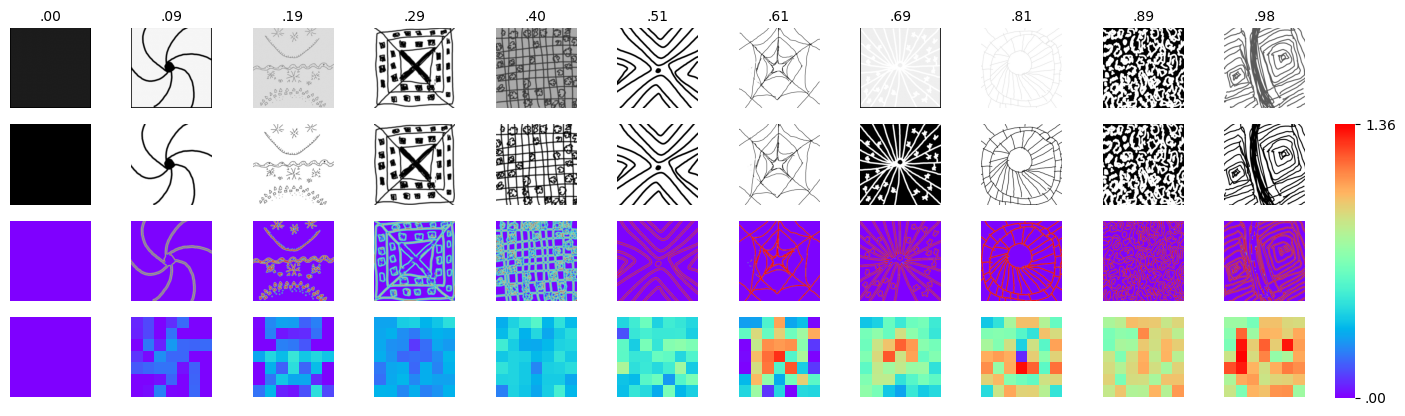

In [52]:
# -------------------------------
# Test on DETAIL (example usage)
# -------------------------------

# Drawings spectrum (uses drawings_detail_normscale computed earlier)
show_feature_spectrum(
    dataset_key="vizex",
    datasets=datasets,
    feature_name="detail",
    feature_map_fn=detail_map_log,
    preprocess_kind="edges",
    value_col="detail",                 # precomputed normalised scalar values
    norm_scale=vizex_detail_normscale,
    n=11,
    bins=7,
)


### Save the detail level feature

In [53]:
# -------------------------------
# Save/merge feature columns to feature CSVs without overwriting other columns
# -------------------------------

def _features_csv_path_for_dataset(dataset_key: str, tables_path: str) -> str:
    return os.path.join(tables_path, f"{dataset_key}_features.csv")


def _choose_merge_key(df: pd.DataFrame) -> list[str]:
    """
    Best-effort merge key selection.
    Prefer stable identifiers; default to ['png_filename'].
    """
    preferred = ["png_filename", "trial_id", "image_id", "stim_id", "stimulus_id"]
    keys = [c for c in preferred if c in df.columns]
    if "png_filename" in keys:
        return ["png_filename"]
    if keys:
        return [keys[0]]
    return []


def upsert_feature_columns_to_csv(
    dataset_key: str,
    datasets: dict,
    *,
    tables_path: str,
    cols_to_override: list[str],
    key_cols: list[str] | None = None,
) -> str:
    """
    Writes feature columns from the in-memory df to disk.

    Behavior:
      - If CSV doesn't exist: creates it from current df (full df).
      - If CSV exists: loads it, merges in the specified columns (override), keeps all other columns.
      - Always overrides cols_to_override with current values (even if present).
      - Does NOT remove any other columns that may have been added elsewhere.

    Returns path saved.
    """
    ds = datasets[dataset_key]
    df_new = ds["df"].copy()

    if key_cols is None:
        key_cols = _choose_merge_key(df_new)

    if not key_cols:
        raise ValueError(
            f"[{dataset_key}] No suitable key columns found to merge on. "
            f"Add a stable ID column (e.g., png_filename) to the dataframe."
        )

    missing = [c for c in key_cols if c not in df_new.columns]
    if missing:
        raise KeyError(f"[{dataset_key}] Missing key columns in current df: {missing}")

    # Ensure keys are strings for stable merging (especially filenames)
    for k in key_cols:
        df_new[k] = df_new[k].astype(str)

    # Ensure cols exist
    for c in cols_to_override:
        if c not in df_new.columns:
            raise KeyError(f"[{dataset_key}] Column '{c}' not found in current df.")

    path = _features_csv_path_for_dataset(dataset_key, tables_path)

    if not os.path.exists(path):
        # First write: save full current df
        df_new.to_csv(path, index=False)
        print(f"[save] created: {path}")
        return path

    # Existing: merge override columns in
    df_old = pd.read_csv(path)

    # Basic sanity checks
    for k in key_cols:
        if k not in df_old.columns:
            raise KeyError(f"[{dataset_key}] Existing CSV missing key column '{k}': {path}")

    for k in key_cols:
        df_old[k] = df_old[k].astype(str)

    # Check uniqueness (best-effort). If not unique, fall back to merge with suffix handling.
    if df_old.duplicated(subset=key_cols).any() or df_new.duplicated(subset=key_cols).any():
        raise ValueError(
            f"[{dataset_key}] Merge key {key_cols} is not unique in old or new data. "
            f"Choose a better key_cols (e.g., include trial_id) or add a unique ID."
        )

    df_patch = df_new[key_cols + cols_to_override].copy()

    merged = df_old.merge(df_patch, on=key_cols, how="left", suffixes=("", "_NEW"))

    # Override columns with new values where available
    for c in cols_to_override:
        newc = f"{c}_NEW"
        if newc not in merged.columns:
            # if merge produced no suffix (unlikely), skip
            continue
        merged[c] = merged[newc]
        merged.drop(columns=[newc], inplace=True)

    merged.to_csv(path, index=False)
    print(f"[save] updated: {path} (overrode: {cols_to_override})")
    return path


In [54]:
# -------------------------------
# Apply save/update to DETAIL feature for all four datasets
# -------------------------------

cols = ["detail_raw", "detail"]

for dk in ["vizex", "vizex_targets"]:
    upsert_feature_columns_to_csv(
        dataset_key=dk,
        datasets=datasets,
        tables_path=tables_path,
        cols_to_override=cols,
        key_cols=["png_filename"],  # explicit; change if you later add a better unique ID
    )


[save] updated: E:\Research2\VizEx_analysis_replication\015_tables\vizex_features.csv (overrode: ['detail_raw', 'detail'])
[save] updated: E:\Research2\VizEx_analysis_replication\015_tables\vizex_targets_features.csv (overrode: ['detail_raw', 'detail'])


In [56]:
# -------------------------------
# Apply save/update to focal point feature for all four datasets
# -------------------------------

cols = ["focal_x_norm", "focal_y_norm"]

for dk in ["vizex", "vizex_targets"]:
    upsert_feature_columns_to_csv(
        dataset_key=dk,
        datasets=datasets,
        tables_path=tables_path,
        cols_to_override=cols,
        key_cols=["png_filename"],  # explicit; change if you later add a better unique ID
    )


[save] updated: E:\Research2\VizEx_analysis_replication\015_tables\vizex_features.csv (overrode: ['focal_x_norm', 'focal_y_norm'])
[save] updated: E:\Research2\VizEx_analysis_replication\015_tables\vizex_targets_features.csv (overrode: ['focal_x_norm', 'focal_y_norm'])


## Directional Features - Tangential and Radial Edge Orientations

### Define the radial and tangential edge orientation features

In [57]:
# -------------------------------
# Radial + tangential orientation feature maps (Sobel; focal-point aware)
# -------------------------------

from scipy.ndimage import sobel  # ensure imported

ORI_KAPPA = 8.0
ORI_EPS = 1e-8


def _sobel_gradients(img: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    gx = sobel(img, axis=1, mode="reflect").astype(np.float32, copy=False)
    gy = sobel(img, axis=0, mode="reflect").astype(np.float32, copy=False)
    return gx, gy


def _focal_norm_to_pixel(
    h: int, w: int, focal_x_norm: float, focal_y_norm: float
) -> tuple[float, float]:
    """
    focal_* are normalized with (0,0) at image center, x right positive, y up positive.
    Image coordinates: x right positive, y down positive -> invert y when mapping.
    """
    cx0 = (w - 1) / 2.0
    cy0 = (h - 1) / 2.0
    cx = cx0 + float(focal_x_norm) * cx0
    cy = cy0 - float(focal_y_norm) * cy0
    return cy, cx


def _soft_directionality_maps(
    img: np.ndarray,
    *,
    focal_x_norm: float = 0.0,
    focal_y_norm: float = 0.0,
    kappa: float = ORI_KAPPA,
    eps: float = ORI_EPS,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns soft radial/tangential activation maps A_r, A_t, and gradient magnitude mag.

    A_* = |g| * exp(-kappa * (1 - c_*))
    where c_* = |(g · u_*)| / (|g| + eps) in [0,1]

    Uses focal point (focal_x_norm, focal_y_norm) as the origin for defining radial/tangential unit vectors.
    """
    img = img.astype(np.float32, copy=False)
    h, w = img.shape[:2]

    cy, cx = _focal_norm_to_pixel(h, w, focal_x_norm, focal_y_norm)

    y, x = np.mgrid[0:h, 0:w]
    dx = (x - cx).astype(np.float32, copy=False)
    dy = (y - cy).astype(np.float32, copy=False)

    r = np.sqrt(dx * dx + dy * dy).astype(np.float32, copy=False) + eps
    ur_x = dx / r
    ur_y = dy / r
    ut_x = -ur_y
    ut_y = ur_x

    gx, gy = _sobel_gradients(img)
    mag = np.hypot(gx, gy).astype(np.float32, copy=False)

    # cosine alignments in [0,1]
    c_r = np.abs(gx * ur_x + gy * ur_y) / (mag + eps)
    c_t = np.abs(gx * ut_x + gy * ut_y) / (mag + eps)

    # soft angular kernels
    sel_r = np.exp(-kappa * (1.0 - c_r)).astype(np.float32, copy=False)
    sel_t = np.exp(-kappa * (1.0 - c_t)).astype(np.float32, copy=False)

    A_r = mag * sel_r
    A_t = mag * sel_t
    return A_r.astype(np.float32, copy=False), A_t.astype(np.float32, copy=False), mag


def r_directionality_map(
    preprocessed_image: np.ndarray,
    *,
    focal_x_norm: float = 0.0,
    focal_y_norm: float = 0.0,
) -> np.ndarray:
    """
    Radial edge orientation map.

    Constructed so that heatmap_to_value(map) reproduces the prior scalar:
      score = mean(A_t) / (mean(mag) + eps)

    Returns a float32 map; no clipping (linear downstream normalization will handle scale).
    """
    A_r, A_t, mag = _soft_directionality_maps(
        preprocessed_image,
        focal_x_norm=focal_x_norm,
        focal_y_norm=focal_y_norm,
        kappa=ORI_KAPPA,
        eps=ORI_EPS,
    )
    denom = float(np.mean(mag[np.isfinite(mag)]) + ORI_EPS) if mag.size else ORI_EPS
    return (A_t / denom).astype(np.float32, copy=False)


def theta_directionality_map(
    preprocessed_image: np.ndarray,
    *,
    focal_x_norm: float = 0.0,
    focal_y_norm: float = 0.0,
) -> np.ndarray:
    """
    Tangential edge orientation map.

    Constructed so that heatmap_to_value(map) reproduces the prior scalar:
      score = mean(A_r) / (mean(mag) + eps)

    Returns a float32 map; no clipping (linear downstream normalization will handle scale).
    """
    A_r, A_t, mag = _soft_directionality_maps(
        preprocessed_image,
        focal_x_norm=focal_x_norm,
        focal_y_norm=focal_y_norm,
        kappa=ORI_KAPPA,
        eps=ORI_EPS,
    )
    denom = float(np.mean(mag[np.isfinite(mag)]) + ORI_EPS) if mag.size else ORI_EPS
    return (A_r / denom).astype(np.float32, copy=False)


### Visualise unprecomputed

VizEx trials | r_directionality | condition=3 | file=saveTime_2510241632__sessionTime_202510241500__participant_CMB3661__trialN_10__trialT_3__fileType_uncropped.png | focal=(0.000,0.000) | mean_raw=0.193388 | mean_norm=1.000000 | norm_scale=45.6421


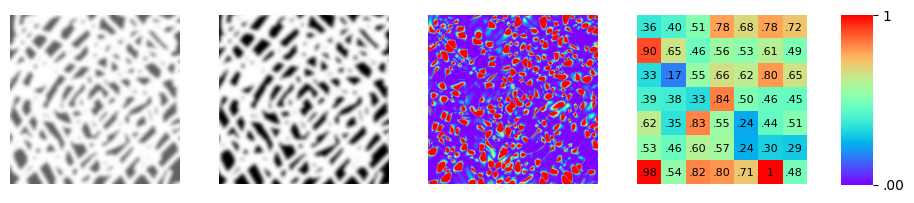

VizEx trials | r_directionality | condition=B10 | file=saveTime_2510251359__sessionTime_202510251200__participant_DIB8045__trialN_15__trialT_B10__fileType_uncropped.png | focal=(0.000,0.000) | mean_raw=0.838814 | mean_norm=1.000000 | norm_scale=45.6421


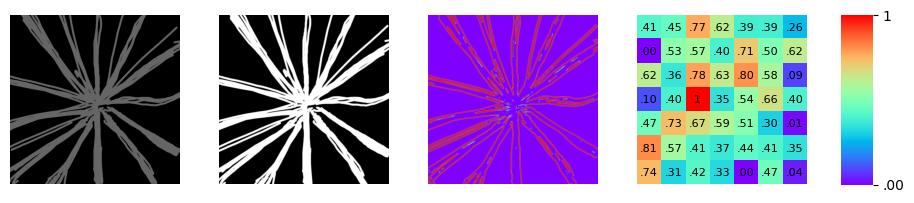

VizEx targets | r_directionality | condition=C11 | file=C11.png | focal=(0.000,0.000) | mean_raw=0.291179 | mean_norm=1.000000 | norm_scale=45.6421


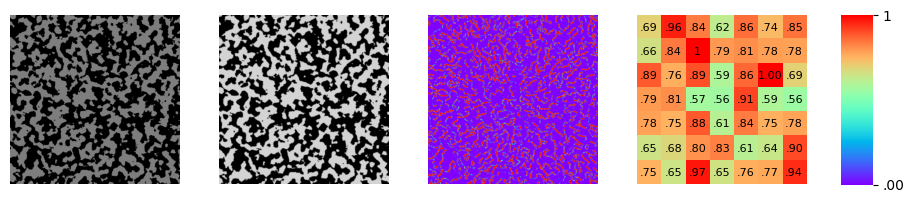

VizEx trials | theta_directionality | condition=4 | file=saveTime_2510171540__sessionTime_202510171420__participant_IJM4327__trialN_6__trialT_4__fileType_uncropped.png | focal=(0.000,0.000) | mean_raw=0.277794 | mean_norm=1.000000 | norm_scale=45.6421


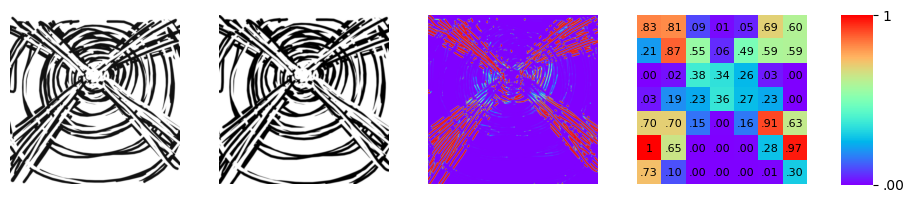

VizEx trials | theta_directionality | condition=6 | file=saveTime_2510241851__sessionTime_202510241700__participant_OBW4271__trialN_13__trialT_6__fileType_uncropped.png | focal=(0.000,0.000) | mean_raw=0.656177 | mean_norm=1.000000 | norm_scale=45.6421


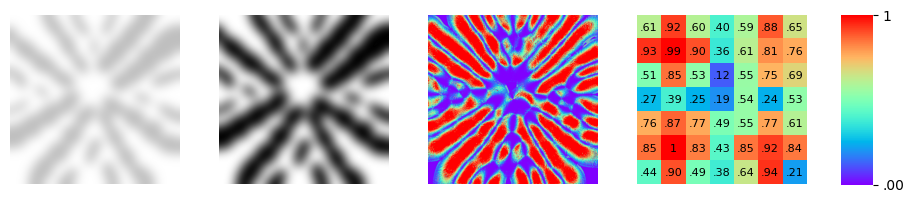

VizEx targets | theta_directionality | condition=B05 | file=B05.png | focal=(0.000,0.000) | mean_raw=0.011504 | mean_norm=0.525045 | norm_scale=45.6421


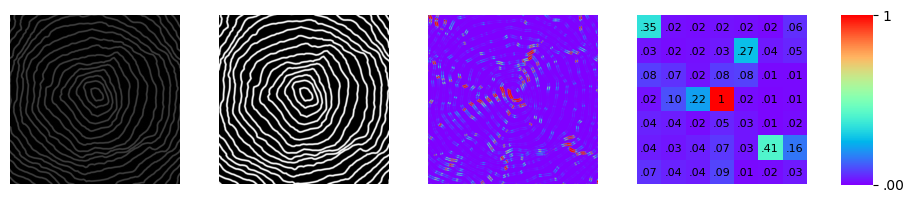

In [60]:
# -------------------------------
# Unsaved precompute diagnostics: run the generic single-image breakdown on orientation features
# -------------------------------

# Per-image structural debug (rescales display to make patterns visible)
run_feature_breakdown_diagnostics(
    df_vizex_features,
    df_vizex_targets_features,
    img_root_trials=raw_data_path_vizex,
    img_root_targets=raw_data_path_targets_vizex,
    feature_name="r_directionality",
    feature_map_fn=r_directionality_map,
    preprocess_kind="edges",
    bins=7,
    norm_scale_trials=norm_scales["vizex"],
    norm_scale_targets=norm_scales["vizex_targets"],
    display_mode="per_image",
)

run_feature_breakdown_diagnostics(
    df_vizex_features,
    df_vizex_targets_features,
    img_root_trials=raw_data_path_vizex,
    img_root_targets=raw_data_path_targets_vizex,
    feature_name="theta_directionality",
    feature_map_fn=r_directionality_map,
    preprocess_kind="edges",
    bins=7,
    norm_scale_trials=norm_scales["vizex"],
    norm_scale_targets=norm_scales["vizex_targets"],
    display_mode="per_image",
)


In [61]:
# -------------------------------
# Apply orientation features across all datasets (compute norm on main; reuse on targets)
# -------------------------------

# ---- Drawings: compute scales on main drawings, reuse for drawings_targets
vizex_r_normscale = apply_feature_to_dataset(
    dataset_key="vizex",
    datasets=datasets,
    feature_key="r_directionality",
    feature_map_fn=r_directionality_map,
    preprocess_kind="edges",
    out_col="r_directionality",
    norm_scale=None,
)

_ = apply_feature_to_dataset(
    dataset_key="vizex_targets",
    datasets=datasets,
    feature_key="r_directionality",
    feature_map_fn=r_directionality_map,
    preprocess_kind="edges",
    out_col="r_directionality",
    norm_scale=vizex_r_normscale,
)

vizex_theta_normscale = apply_feature_to_dataset(
    dataset_key="vizex",
    datasets=datasets,
    feature_key="theta_directionality",
    feature_map_fn=theta_directionality_map,
    preprocess_kind="edges",
    out_col="theta_directionality",
    norm_scale=None,
)

_ = apply_feature_to_dataset(
    dataset_key="vizex_targets",
    datasets=datasets,
    feature_key="theta_directionality",
    feature_map_fn=theta_directionality_map,
    preprocess_kind="edges",
    out_col="theta_directionality",
    norm_scale=vizex_theta_normscale,
)

[vizex | r_directionality] computed norm_scale (Q0.95→1): 1.3824
[vizex_targets | r_directionality] using provided norm_scale: 1.3824
[vizex | theta_directionality] computed norm_scale (Q0.95→1): 1.281
[vizex_targets | theta_directionality] using provided norm_scale: 1.281


VizEx | r_directionality | min=0.0000, mean=0.4181, sd=0.2853, max=1.3012 | norm_scale=1.3824


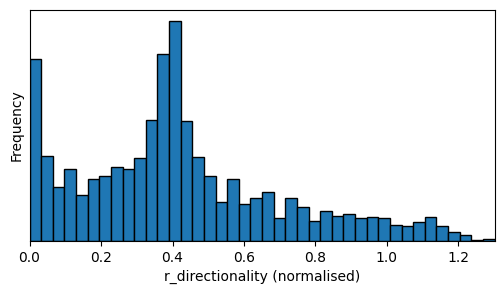

VizEx | theta_directionality | min=0.0000, mean=0.4312, sd=0.2734, max=1.2368 | norm_scale=1.281


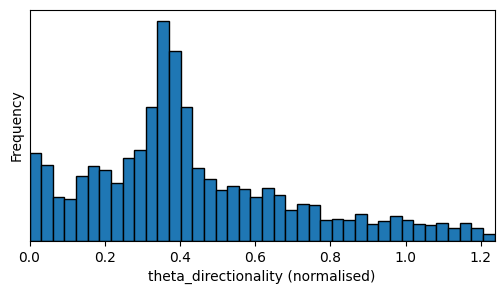

In [63]:
# -------------------------------
# Histograms of NORMALISED distributions (main datasets only)
# -------------------------------

# Drawings
plot_feature_distribution(
    dataset_key="vizex",
    datasets=datasets,
    feature_name="r_directionality",
    feature_col="r_directionality",
    norm_scale=vizex_r_normscale,
    bins=40,
)

plot_feature_distribution(
    dataset_key="vizex",
    datasets=datasets,
    feature_name="theta_directionality",
    feature_col="theta_directionality",
    norm_scale=vizex_theta_normscale,
    bins=40,
)


VizEx | r_directionality spectrum | n=11 | value_col='r_directionality' | norm_scale=1.3824 | vmin=0 | vmax=4.40731


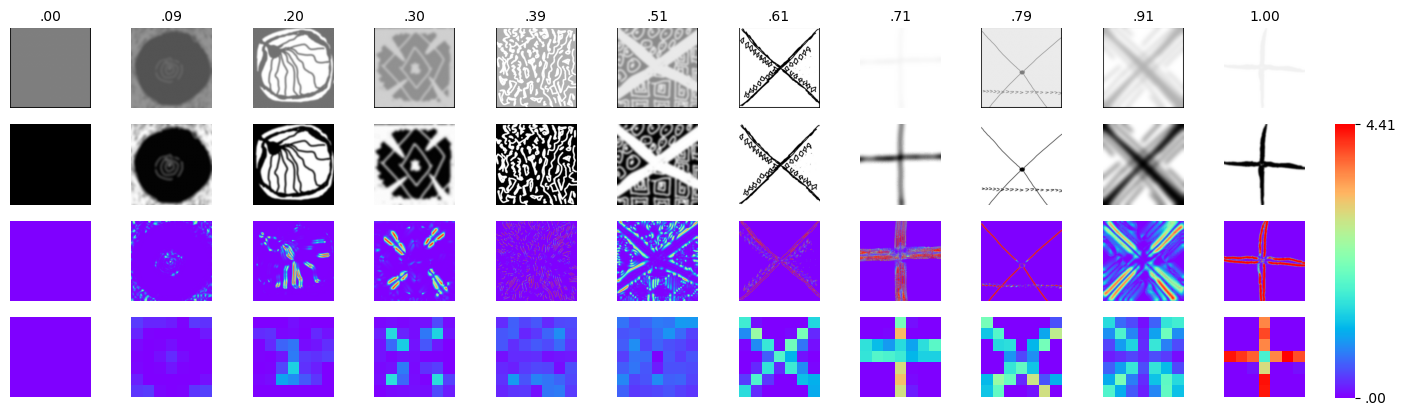

VizEx | theta_directionality spectrum | n=11 | value_col='theta_directionality' | norm_scale=1.281 | vmin=0 | vmax=3.89581


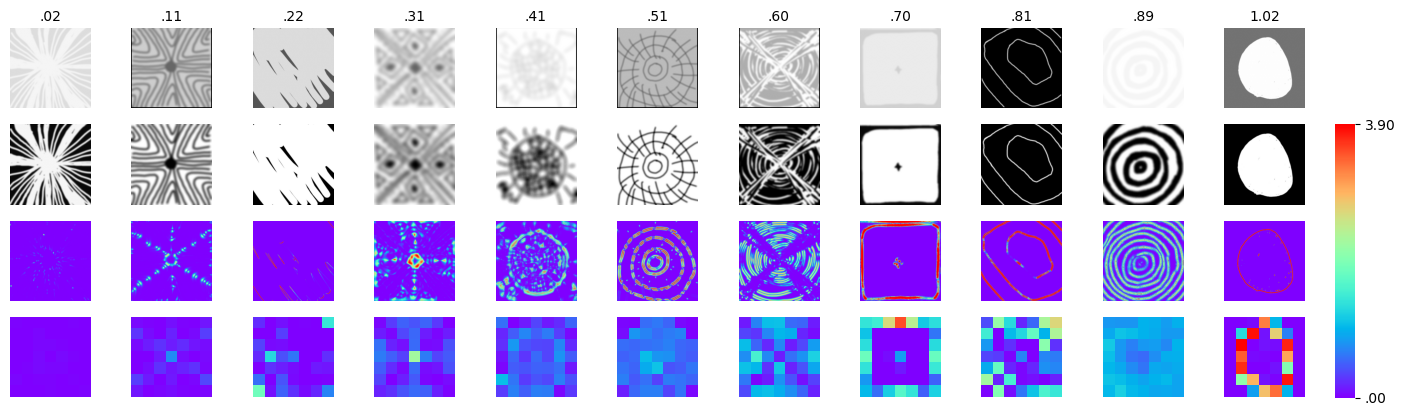

In [64]:
# -------------------------------
# Spectrum visualizations (main datasets only; uses precomputed scalars to select images)
# -------------------------------

# Drawings spectra
show_feature_spectrum(
    dataset_key="vizex",
    datasets=datasets,
    feature_name="r_directionality",
    feature_map_fn=r_directionality_map,
    preprocess_kind="edges",
    value_col="r_directionality",
    norm_scale=vizex_r_normscale,
    n=11,
    bins=7,
    seed=None,            # set an int for reproducible selection
)

show_feature_spectrum(
    dataset_key="vizex",
    datasets=datasets,
    feature_name="theta_directionality",
    feature_map_fn=theta_directionality_map,
    preprocess_kind="edges",
    value_col="theta_directionality",
    norm_scale=vizex_theta_normscale,
    n=11,
    bins=7,
    seed=None,
)


In [66]:
# -------------------------------
# Save orientation feature columns to CSVs (override only these columns)
# -------------------------------

cols_to_override = [
    "r_directionality_raw",
    "r_directionality",
    "theta_directionality_raw",
    "theta_directionality",
]

for dk in ["vizex", "vizex_targets"]:
    upsert_feature_columns_to_csv(
        dataset_key=dk,
        datasets=datasets,
        tables_path=tables_path,
        cols_to_override=cols_to_override,
        key_cols=["png_filename"],
    )


[save] updated: E:\Research2\VizEx_analysis_replication\015_tables\vizex_features.csv (overrode: ['r_directionality_raw', 'r_directionality', 'theta_directionality_raw', 'theta_directionality'])
[save] updated: E:\Research2\VizEx_analysis_replication\015_tables\vizex_targets_features.csv (overrode: ['r_directionality_raw', 'r_directionality', 'theta_directionality_raw', 'theta_directionality'])


## Brightness and Contrast Features

In [67]:
# -------------------------------
# Brightness + contrast feature maps (interface only; no dataset normalisation)
# -------------------------------

def brightness_map(
    preprocessed_image: np.ndarray,
    *,
    focal_x_norm: float = 0.0,
    focal_y_norm: float = 0.0,
) -> np.ndarray:
    """
    Brightness map: pixel intensity itself.
    Overall brightness = mean(map).
    Focal point ignored (kept for uniform signature).
    """
    return preprocessed_image.astype(np.float32, copy=False)


def contrast_map_rms_sq(
    preprocessed_image: np.ndarray,
    *,
    focal_x_norm: float = 0.0,
    focal_y_norm: float = 0.0,
) -> np.ndarray:
    """
    RMS contrast (squared-deviation map).
    If you use mean(map) you get VARIANCE; if you want RMS (std), take sqrt(mean(map)).

    This map is useful because it can be binned and averaged consistently.
    Focal point ignored.
    """
    img = preprocessed_image.astype(np.float32, copy=False)
    mu = float(np.mean(img[np.isfinite(img)])) if img.size else 0.0
    return (img - mu) ** 2




In [68]:
# -------------------------------
# Apply brightness + contrast across interface + interface_targets (NO normalisation)
# -------------------------------



# Brightness (mean pixel intensity) — keep norm_scale=1.0
vizex_brightness_normscale = apply_feature_to_dataset(
    dataset_key="vizex",
    datasets=datasets,
    feature_key="brightness",
    feature_map_fn=brightness_map,
    preprocess_kind="intensity",
    out_col="brightness",
    norm_scale=1.0,          # explicit: no dataset normalisation
    value_from_map_fn=value_from_map_mean,
)

_ = apply_feature_to_dataset(
    dataset_key="vizex_targets",
    datasets=datasets,
    feature_key="brightness",
    feature_map_fn=brightness_map,
    preprocess_kind="intensity",
    out_col="brightness",
    norm_scale=1.0,
    value_from_map_fn=value_from_map_mean,
)

# Contrast (RMS contrast) — computed from squared-deviation map via sqrt(mean)
vizex_contrast_normscale = apply_feature_to_dataset(
    dataset_key="vizex",
    datasets=datasets,
    feature_key="contrast",
    feature_map_fn=contrast_map_rms_sq,
    preprocess_kind="intensity",
    out_col="contrast",
    norm_scale=1.0,
    value_from_map_fn=value_from_map_rms,
)

_ = apply_feature_to_dataset(
    dataset_key="vizex_targets",
    datasets=datasets,
    feature_key="contrast",
    feature_map_fn=contrast_map_rms_sq,
    preprocess_kind="intensity",
    out_col="contrast",
    norm_scale=1.0,
    value_from_map_fn=value_from_map_rms,
)


[vizex | brightness] using provided norm_scale: 1
[vizex_targets | brightness] using provided norm_scale: 1
[vizex | contrast] using provided norm_scale: 1
[vizex_targets | contrast] using provided norm_scale: 1


VizEx | brightness | min=0.0000, mean=0.6996, sd=0.2545, max=1.0000 | norm_scale=1


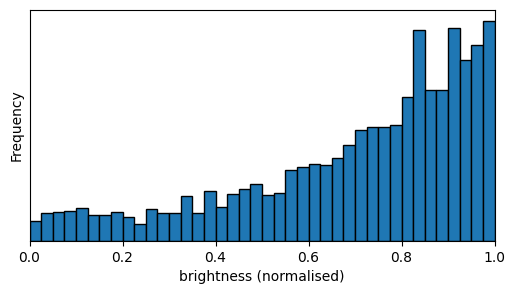

VizEx | contrast | min=0.0000, mean=0.1438, sd=0.1128, max=0.4971 | norm_scale=1


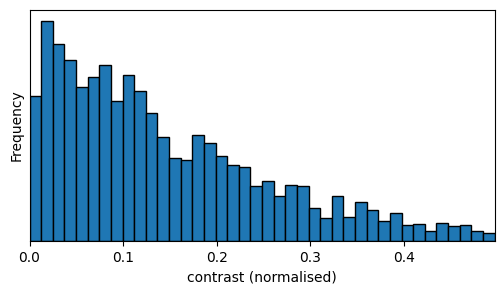

In [69]:
# -------------------------------
# Histograms (interface only; values are NOT dataset-normalised)
# -------------------------------

plot_feature_distribution(
    dataset_key="vizex",
    datasets=datasets,
    feature_name="brightness",
    feature_col="brightness",
    norm_scale=1.0,
    bins=40,
)

plot_feature_distribution(
    dataset_key="vizex",
    datasets=datasets,
    feature_name="contrast",
    feature_col="contrast",
    norm_scale=1.0,
    bins=40,
)


VizEx | brightness spectrum | n=11 | value_col='brightness' | norm_scale=1 | vmin=0 | vmax=1


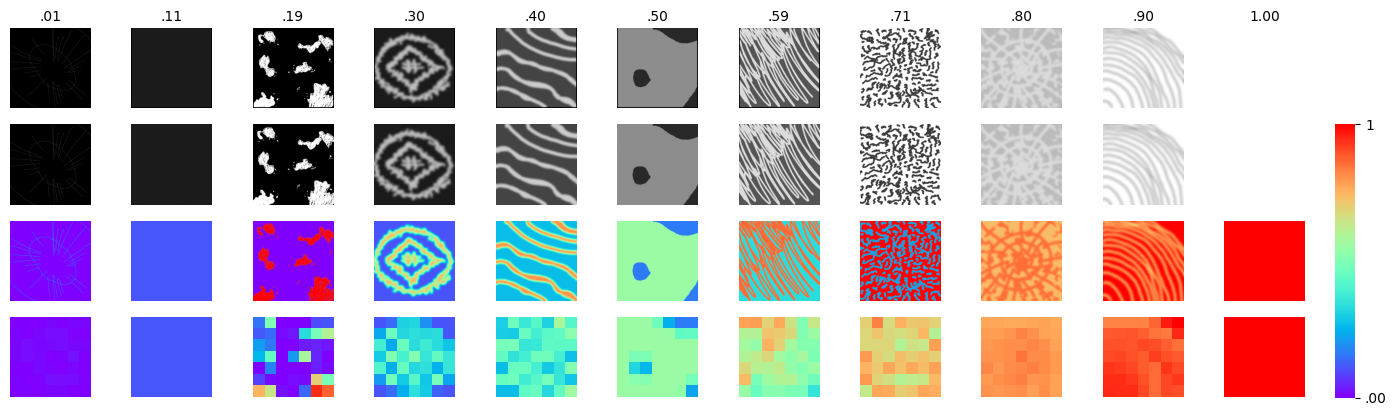

VizEx | contrast spectrum | n=11 | value_col='contrast' | norm_scale=1 | vmin=0 | vmax=0.5


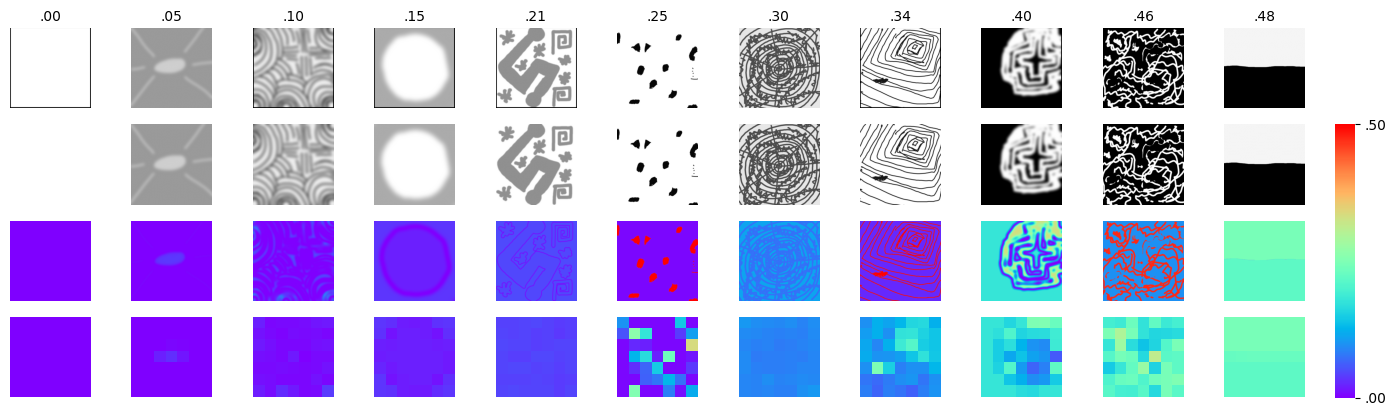

In [71]:
# -------------------------------
# Spectra (interface only; uses stored scalar values to pick images; recomputes maps)
# -------------------------------



show_feature_spectrum(
    dataset_key="vizex",
    datasets=datasets,
    feature_name="brightness",
    feature_map_fn=brightness_map,
    preprocess_kind="intensity",
    value_col="brightness",
    norm_scale=1.0,
    n=11,
    bins=7,
    seed=None,
)

show_feature_spectrum(
    dataset_key="vizex",
    datasets=datasets,
    feature_name="contrast",
    feature_map_fn=contrast_map_rms_sq,
    preprocess_kind="intensity",
    value_col="contrast",
    norm_scale=1.0,
    n=11,
    bins=7,
    seed=None,
    color_scale = [0, 0.5]
)



In [73]:
# -------------------------------
# Save brightness + contrast columns to CSVs (interface + interface_targets only)
# -------------------------------

cols_to_override = [
    "brightness_raw",
    "brightness",
    "contrast_raw",
    "contrast",
]

for dk in ["vizex", "vizex_targets"]:
    upsert_feature_columns_to_csv(
        dataset_key=dk,
        datasets=datasets,
        tables_path=tables_path,
        cols_to_override=cols_to_override,
        key_cols=["png_filename"],
    )


[save] updated: E:\Research2\VizEx_analysis_replication\015_tables\vizex_features.csv (overrode: ['brightness_raw', 'brightness', 'contrast_raw', 'contrast'])
[save] updated: E:\Research2\VizEx_analysis_replication\015_tables\vizex_targets_features.csv (overrode: ['brightness_raw', 'brightness', 'contrast_raw', 'contrast'])


## Heatmaps

In [93]:
# -------------------------------
# Heatmap settings (shared)
# -------------------------------

N_BINS = 35  # nxn bins
ROBUST_METHOD = "trimmed_mean"  # "median" or "trimmed_mean"
TRIM_Q = 0.10             # only used if ROBUST_METHOD == "trimmed_mean"

# Rendering defaults for paper-ready exports
HEATMAP_FIGSIZE = (3.0, 3.0)
SCALE_FIGSIZE = (0.6, 3.0)
DPI = 300

# Condition label maps (optional; used only for save names / prints)
CONDITION_LABELS_NUM = {
    "1": "2.5 Hz",
    "2": "5 Hz",
    "3": "10 Hz",
    "4": "15 Hz",
    "5": "20 Hz",
    "6": "40 Hz",
    "7": "80 Hz",
}

EXPERIMENTAL_CONDS = ("1", "2", "3", "4", "5", "6", "7")


In [94]:
# -------------------------------
# Shared helpers
# -------------------------------

import math
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def _normalize_cond_set(conds):
    if conds is None:
        return None
    return set(str(c) for c in conds)

def _ceil_to_2dp(x: float) -> float:
    if not np.isfinite(x):
        return 1.0
    return math.ceil(x * 100.0) / 100.0

def _robust_reduce(stack: np.ndarray, method: str = ROBUST_METHOD, trim_q: float = TRIM_Q) -> np.ndarray:
    """
    stack: (n_images, n_bins, n_bins) or (n_images, n_bins, n_bins, channels)
    returns: (n_bins, n_bins) or (n_bins, n_bins, channels)
    """
    if stack.size == 0:
        raise ValueError("Empty stack passed to _robust_reduce")

    if method == "median":
        return np.nanmedian(stack, axis=0)

    if method == "trimmed_mean":
        lo = np.nanquantile(stack, trim_q, axis=0)
        hi = np.nanquantile(stack, 1.0 - trim_q, axis=0)
        clipped = np.clip(stack, lo, hi)
        return np.nanmean(clipped, axis=0)

    raise ValueError(f"Unknown robust method: {method}")

def _bin_mean_map(map2d: np.ndarray, n_bins: int = N_BINS) -> np.ndarray:
    """
    map2d: (H,W) float
    returns (n_bins,n_bins) by mean within each bin.
    """
    h, w = map2d.shape
    out = np.full((n_bins, n_bins), np.nan, dtype=np.float32)
    for i in range(n_bins):
        y0 = int(i * h / n_bins)
        y1 = int((i + 1) * h / n_bins)
        for j in range(n_bins):
            x0 = int(j * w / n_bins)
            x1 = int((j + 1) * w / n_bins)
            patch = map2d[y0:y1, x0:x1]
            vals = patch[np.isfinite(patch)]
            out[i, j] = float(vals.mean()) if vals.size else np.nan
    return out

def _save_tight(fig, path: str, pad: float = 0.0):
    fig.savefig(path, dpi=DPI, bbox_inches="tight", pad_inches=pad)

def _safe_label(cond) -> str:
    s = str(cond)
    return CONDITION_LABELS_NUM.get(s, s)

def _get_condition_values(
    df: pd.DataFrame,
    condition_col: str = "condition_code",
    *,
    condition_filter=EXPERIMENTAL_CONDS,
):
    vals = df[condition_col].dropna().astype(str)

    cf = _normalize_cond_set(condition_filter)
    if cf is not None:
        vals = vals[vals.isin(cf)]

    uniq = vals.unique().tolist()

    try:
        uniq = sorted(uniq, key=lambda x: float(x))
    except Exception:
        uniq = sorted(uniq)

    return uniq


In [95]:
# -------------------------------
# Core: compute robust binned heatmap across a dataframe slice
# -------------------------------

def robust_binned_heatmap_for_group(
    df_group: pd.DataFrame,
    *,
    dataset_key: str,
    datasets: dict,
    feature_map_fn,
    preprocess_kind: str,
    n_bins: int = N_BINS,
    norm_scale: float = 1.0,
    # focal points must already be in df_group as focal_x_norm/focal_y_norm
) -> np.ndarray:
    """
    For each image:
      - load
      - preprocess (domain_key × preprocess_kind)
      - compute feature map (H,W)
      - bin -> (n_bins,n_bins) by mean
    Then robust-reduce across images (median or trimmed mean).
    Finally apply linear scaling: heatmap *= norm_scale
    """
    ds = datasets[dataset_key]
    img_root = ds["image_path"]
    domain_key = ds["domain_key"]

    binned_list = []
    for _, row in df_group.iterrows():
        fname = row.get("png_filename", None)
        if not isinstance(fname, str) or not fname:
            continue
        path = os.path.join(img_root, fname)
        if not os.path.exists(path):
            continue

        img = load_grayscale_image(path)  # float32 in [0,1]
        pre = preprocess_image(img, domain_key=domain_key, preprocess_kind=preprocess_kind)

        fx = float(row.get("focal_x_norm", 0.0))
        fy = float(row.get("focal_y_norm", 0.0))

        fmap = feature_map_fn(pre, focal_x_norm=fx, focal_y_norm=fy)
        binned = _bin_mean_map(fmap, n_bins=n_bins)
        binned_list.append(binned)

    if len(binned_list) == 0:
        return np.full((n_bins, n_bins), np.nan, dtype=np.float32)

    stack = np.stack(binned_list, axis=0)  # (n_img, n_bins, n_bins)
    out = _robust_reduce(stack).astype(np.float32, copy=False)
    out *= float(norm_scale)
    return out


### Directionality Heatmaps

In [96]:
# -------------------------------
# Directionality magnitude maps (no angular selectivity)
# -------------------------------

from scipy.ndimage import sobel

def sobel_radial_tangential_magnitude_maps(
    img_pre: np.ndarray,
    *,
    focal_x_norm: float = 0.0,
    focal_y_norm: float = 0.0,
    eps: float = 1e-8,
):
    """
    Returns (G_r, G_t) where:
      G_r = |g · u_r|
      G_t = |g · u_t|
    and u_r/u_t are unit radial/tangential vectors around focal point.

    Property:
      sqrt(G_r^2 + G_t^2) == |g| (up to numerical error), so you can recover Sobel magnitude.
    """
    img = img_pre.astype(np.float32, copy=False)
    h, w = img.shape

    # focal in "graph" normalized coords where center is (0,0)
    # convert to pixel coords
    cx = (w - 1) / 2.0 + focal_x_norm * ((w - 1) / 2.0)
    cy = (h - 1) / 2.0 + focal_y_norm * ((h - 1) / 2.0)

    y, x = np.mgrid[0:h, 0:w]
    dx = x - cx
    dy = y - cy

    r = np.sqrt(dx * dx + dy * dy) + eps
    ur_x = dx / r
    ur_y = dy / r
    ut_x = -ur_y
    ut_y = ur_x

    gx = sobel(img, axis=1, mode="reflect")
    gy = sobel(img, axis=0, mode="reflect")

    gt = np.abs(gx * ur_x + gy * ur_y)
    gr = np.abs(gx * ut_x + gy * ut_y)
    return gr.astype(np.float32, copy=False), gt.astype(np.float32, copy=False)


In [97]:

# -------------------------------
# Directionality heatmaps (RGB: radial=G, tangential=R)
# -------------------------------

def _rgb_from_rg(gr: np.ndarray, gt: np.ndarray, vmax: float) -> np.ndarray:
    """
    gr,gt: (n,n) scaled values
    vmax: max for normalization to [0,1]

    Mapping:
      radial     -> Green
      tangential -> Red
    """
    denom = float(vmax) if (np.isfinite(vmax) and vmax > 0) else 1.0
    G = np.clip(gr / denom, 0.0, 1.0)  # radial -> G
    R = np.clip(gt / denom, 0.0, 1.0)  # tangential -> R
    B = np.zeros_like(R)
    rgb = np.stack([R, G, B], axis=-1)
    return rgb


def render_and_save_rgb_heatmap(rgb: np.ndarray, *, save_path: str, figsize=HEATMAP_FIGSIZE):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(rgb, interpolation="nearest", origin="lower")
    ax.set_axis_off()
    ax.set_position([0, 0, 1, 1])
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()
    _save_tight(fig, save_path, pad=0.0)
    plt.close(fig)
    print(f"saved: {save_path}")


def make_rg_scale_bar(
    *,
    vmax: float,
    channel: str,  # "radial" or "tangential"
    save_path: str,
    height_in=SCALE_FIGSIZE[1],
    width_in=SCALE_FIGSIZE[0],
    tick_step: float | None = None,
    text_size: int = 11,
):
    """
    Vertical bar:
      black->green for radial
      black->red   for tangential
    """
    vmax = float(vmax)
    vmax = max(vmax, 0.01)

    if tick_step is None:
        tick_step = max(_ceil_to_2dp(vmax / 4.0), 0.01)

    n = 256
    t = np.linspace(1.0, 0.0, n).reshape(n, 1)  # 1 at top

    if channel == "radial":
        rgb = np.concatenate([np.zeros_like(t), t, np.zeros_like(t)], axis=1).reshape(n, 1, 3)
        ylabel = "Radial"
    elif channel == "tangential":
        rgb = np.concatenate([t, np.zeros_like(t), np.zeros_like(t)], axis=1).reshape(n, 1, 3)
        ylabel = "Tangential"
    else:
        raise ValueError("channel must be 'radial' or 'tangential'")

    fig, ax = plt.subplots(figsize=(width_in, height_in))
    ax.imshow(rgb, aspect="auto", origin="upper")
    ax.set_xticks([])
    ax.set_ylabel(ylabel, fontsize=text_size)

    span = vmax
    n_steps = max(int(np.ceil(span / tick_step)), 1)
    ticks = np.arange(n_steps + 1, dtype=np.float32) * (span / n_steps)
    ticks[0] = 0.0
    ticks[-1] = vmax

    y_pos = (1.0 - (ticks / vmax)) * (n - 1)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{t:.2f}" for t in ticks], fontsize=text_size)

    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

    plt.show()
    _save_tight(fig, save_path, pad=0.05)
    plt.close(fig)
    print(f"saved: {save_path}")


def hue_shift_image_file(path_in: str, path_out: str, hue_degrees: float = -135.0):
    """
    Hue shift for saved PNGs (RGB). Uses HSV conversion.
    """
    img = Image.open(path_in).convert("RGB")
    arr = np.asarray(img).astype(np.float32) / 255.0

    import colorsys
    h, w, _ = arr.shape
    out = np.empty_like(arr)
    dh = (hue_degrees / 360.0) % 1.0

    for y in range(h):
        for x in range(w):
            r, g, b = arr[y, x]
            hh, ss, vv = colorsys.rgb_to_hsv(r, g, b)
            hh = (hh + dh) % 1.0
            rr, gg, bb = colorsys.hsv_to_rgb(hh, ss, vv)
            out[y, x] = (rr, gg, bb)

    out_img = Image.fromarray(np.clip(out * 255.0, 0, 255).astype(np.uint8))
    out_img.save(path_out)
    print(f"hue-shift saved: {path_out}")



vizex directionality vmax (shared across conditions) = 0.16
vizex | condition=1


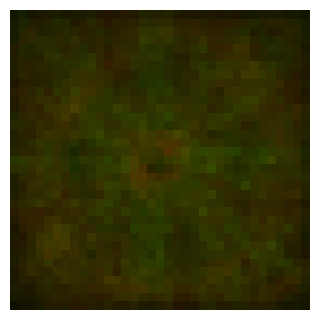

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_2.5 Hz_dir_heatmap.png
vizex | condition=2


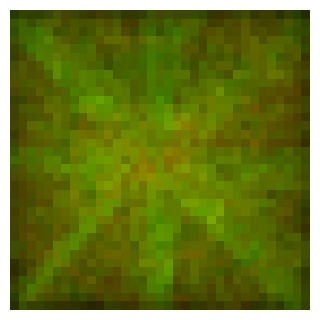

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_5 Hz_dir_heatmap.png
vizex | condition=3


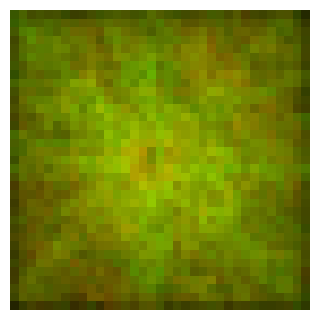

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_10 Hz_dir_heatmap.png
vizex | condition=4


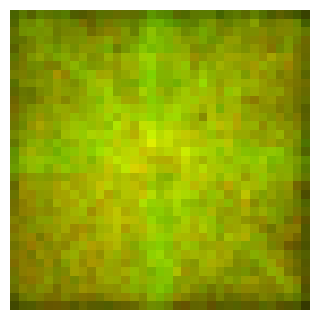

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_15 Hz_dir_heatmap.png
vizex | condition=5


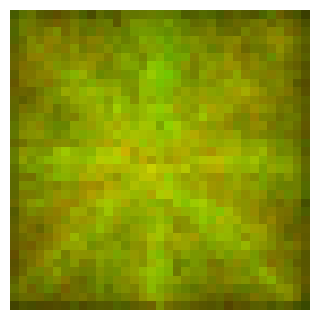

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_20 Hz_dir_heatmap.png
vizex | condition=6


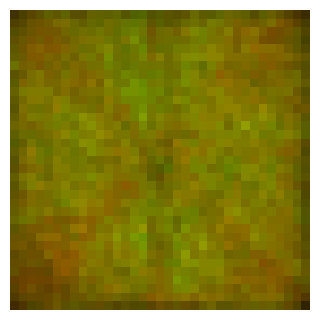

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_40 Hz_dir_heatmap.png
vizex | condition=7


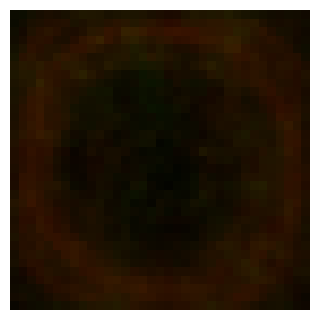

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_80 Hz_dir_heatmap.png


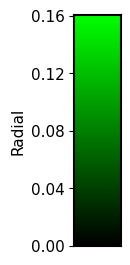

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_dir_scale_radial.png


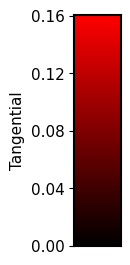

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_dir_scale_tangential.png


In [104]:
# -------------------------------
# Directionality heatmaps: compute + render + save
# -------------------------------

def directionality_heatmaps_for_dataset(
    *,
    dataset_key: str,
    datasets: dict,
    preprocess_kind: str = "edges",
    n_bins: int = N_BINS,
    # IMPORTANT: use the already-declared dataset-level norm scales
    r_normscale: float,
    theta_normscale: float,
    save_prefix: str,
    max_val_override: float | None = None,
):
    ds = datasets[dataset_key]
    df = ds["df"]

    conds = _get_condition_values(df, "condition_code")

    # 1) compute all condition heatmaps first (so we can set a shared vmax within dataset)
    hm_by_cond = {}
    max_val = 0.0

    for cond in conds:
        df_g = df[df["condition_code"].astype(str) == str(cond)]
        if df_g.empty:
            continue

        # binned robust averages for each channel
        def _rad_map(pre, focal_x_norm=0.0, focal_y_norm=0.0):
            gr, _ = sobel_radial_tangential_magnitude_maps(
                pre, focal_x_norm=focal_x_norm, focal_y_norm=focal_y_norm
            )
            return gr

        def _tan_map(pre, focal_x_norm=0.0, focal_y_norm=0.0):
            _, gt = sobel_radial_tangential_magnitude_maps(
                pre, focal_x_norm=focal_x_norm, focal_y_norm=focal_y_norm
            )
            return gt

        gr_bin = robust_binned_heatmap_for_group(
            df_g, dataset_key=dataset_key, datasets=datasets,
            feature_map_fn=_rad_map, preprocess_kind=preprocess_kind,
            n_bins=n_bins, norm_scale=r_normscale
        )
        gt_bin = robust_binned_heatmap_for_group(
            df_g, dataset_key=dataset_key, datasets=datasets,
            feature_map_fn=_tan_map, preprocess_kind=preprocess_kind,
            n_bins=n_bins, norm_scale=theta_normscale
        )

        hm_by_cond[str(cond)] = (gr_bin, gt_bin)
        max_val = max(max_val, float(np.nanmax(gr_bin)), float(np.nanmax(gt_bin)))
    
    if max_val_override is not None:
        max_val = float(max_val_override)

    # 2) shared vmax within dataset (not across datasets)
    vmax = _ceil_to_2dp(max_val)
    if vmax <= 0:
        vmax = 0.01

    print(f"{dataset_key} directionality vmax (shared across conditions) = {vmax:.2f}")

    # 3) render heatmaps
    saved_paths = []
    for cond_str, (gr_bin, gt_bin) in hm_by_cond.items():
        print(f"{dataset_key} | condition={cond_str}")

        rgb = _rgb_from_rg(gr_bin, gt_bin, vmax=vmax)

        save_name = f"{save_prefix}_{dataset_key}_{_safe_label(cond_str)}_dir_heatmap.png"
        save_path = os.path.join(viz_path, save_name)
        render_and_save_rgb_heatmap(rgb, save_path=save_path, figsize=HEATMAP_FIGSIZE)
        saved_paths.append(save_path)

    # 4) scales (two separate bars)
    rad_scale_path = os.path.join(viz_path, f"{save_prefix}_{dataset_key}_dir_scale_radial.png")
    tan_scale_path = os.path.join(viz_path, f"{save_prefix}_{dataset_key}_dir_scale_tangential.png")
    make_rg_scale_bar(vmax=vmax, channel="radial", save_path=rad_scale_path)
    make_rg_scale_bar(vmax=vmax, channel="tangential", save_path=tan_scale_path)

    return saved_paths, rad_scale_path, tan_scale_path


# ---- CALLS: drawings + interface ----

draw_dir_paths, draw_rad_scale, draw_tan_scale = directionality_heatmaps_for_dataset(
    dataset_key="vizex",
    datasets=datasets,
    r_normscale=vizex_r_normscale,
    theta_normscale=vizex_theta_normscale,
    save_prefix="hm",
    #max_val_override=0.34 ## overriding max values to match across datasets
)



### Detail heatmaps

vizex detail vmax (shared across all outputs) = 0.33
vizex | condition=1


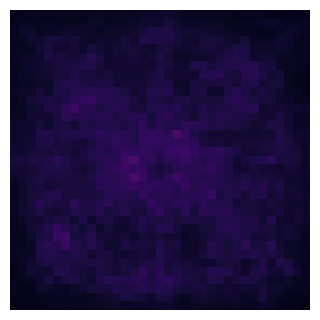

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_2.5 Hz_detail_heatmap.png
vizex | condition=2


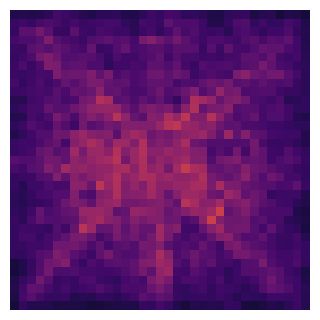

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_5 Hz_detail_heatmap.png
vizex | condition=3


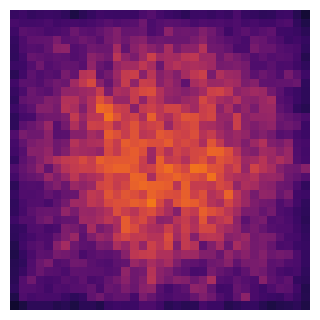

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_10 Hz_detail_heatmap.png
vizex | condition=4


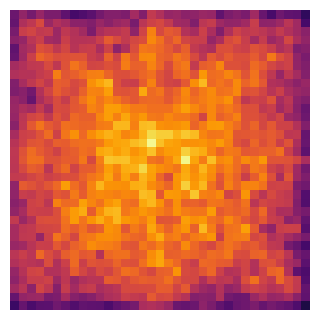

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_15 Hz_detail_heatmap.png
vizex | condition=5


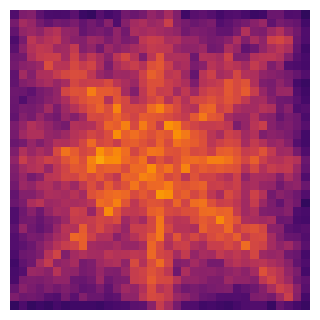

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_20 Hz_detail_heatmap.png
vizex | condition=6


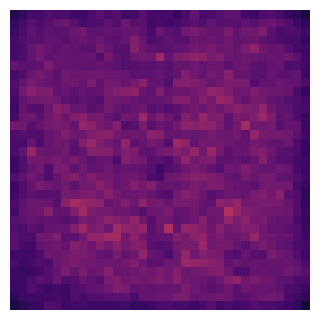

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_40 Hz_detail_heatmap.png
vizex | condition=7


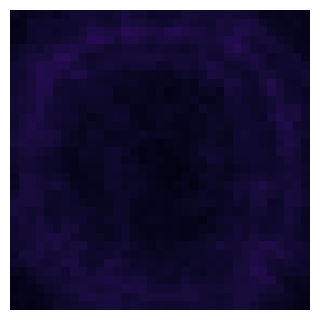

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_80 Hz_detail_heatmap.png
vizex | condition=pooled_no_7


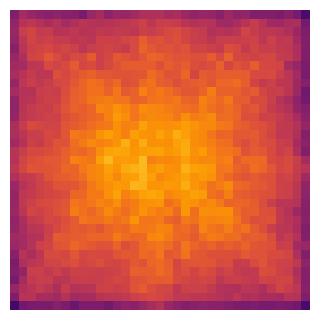

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_pooled_no_7_detail_heatmap.png


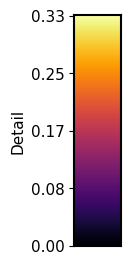

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_detail_scale.png


In [102]:
def _robust_reduce_stack(stack: np.ndarray, method: str = "median") -> np.ndarray:
    """
    stack: (N, H, W)
    Returns robust reduction across axis 0, ignoring NaNs.
    """
    if method == "median":
        return np.nanmedian(stack, axis=0)
    elif method == "trimmed_mean":
        # simple symmetric trim; requires scipy for a true trimmed mean, so do a manual fallback
        # Here we do a winsor-ish approach by clipping to per-pixel quantiles.
        lo = np.nanquantile(stack, 0.1, axis=0)
        hi = np.nanquantile(stack, 0.9, axis=0)
        clipped = np.clip(stack, lo[None, :, :], hi[None, :, :])
        return np.nanmean(clipped, axis=0)
    else:
        raise ValueError(f"Unknown method: {method}")


def pooled_experimental_detail_heatmap(
    *,
    df: pd.DataFrame,
    dataset_key: str,
    datasets: dict,
    preprocess_kind: str,
    n_bins: int,
    normscale: float,
    control_code: str = "7",
    participant_col: str = "participant_id",
    robust_method: str = "median",
) -> np.ndarray:
    """
    Computes one pooled (experimental-only) heatmap robustly, excluding control_code.
    Robustness here is across participants: build a heatmap per participant, then robustly average.
    """
    df_exp = df[df["condition_code"].astype(str) != str(control_code)].copy()
    if df_exp.empty:
        raise ValueError("No experimental rows after excluding control condition.")

    if participant_col not in df_exp.columns:
        # fallback: just do pooled robust binned heatmap across all trials
        return robust_binned_heatmap_for_group(
            df_exp,
            dataset_key=dataset_key,
            datasets=datasets,
            feature_map_fn=detail_map_log,
            preprocess_kind=preprocess_kind,
            n_bins=n_bins,
            norm_scale=normscale,
        )

    hms = []
    for pid, df_p in df_exp.groupby(participant_col):
        if df_p.empty:
            continue
        hm_p = robust_binned_heatmap_for_group(
            df_p,
            dataset_key=dataset_key,
            datasets=datasets,
            feature_map_fn=detail_map_log,
            preprocess_kind=preprocess_kind,
            n_bins=n_bins,
            norm_scale=normscale,
        )
        hms.append(hm_p)

    if len(hms) == 0:
        raise ValueError("No participant heatmaps could be computed for pooled experimental data.")

    stack = np.stack(hms, axis=0)  # (Nparticipants, H, W)
    return _robust_reduce_stack(stack, method=robust_method)


def detail_heatmaps_for_dataset(
    *,
    dataset_key: str,
    datasets: dict,
    preprocess_kind: str = "edges",
    n_bins: int = N_BINS,
    normscale: float,
    save_prefix: str,
    cmap: str = "inferno",
    control_code: str = "7",                 # <-- added
    participant_col: str = "participant_id", # <-- added (set to your actual column name)
    pooled_robust_method: str = "median",    # <-- added
):
    ds = datasets[dataset_key]
    df = ds["df"]
    conds = _get_condition_values(df, "condition_code")

    hm_by_cond = {}
    max_val = 0.0

    # 1) per-condition heatmaps (as before)
    for cond in conds:
        df_g = df[df["condition_code"].astype(str) == str(cond)]
        if df_g.empty:
            continue

        hm = robust_binned_heatmap_for_group(
            df_g,
            dataset_key=dataset_key,
            datasets=datasets,
            feature_map_fn=detail_map_log,
            preprocess_kind=preprocess_kind,
            n_bins=n_bins,
            norm_scale=normscale,
        )
        hm_by_cond[str(cond)] = hm
        max_val = max(max_val, float(np.nanmax(hm)))

    # 2) pooled experimental (exclude control_code)
    hm_pooled_exp = pooled_experimental_detail_heatmap(
        df=df,
        dataset_key=dataset_key,
        datasets=datasets,
        preprocess_kind=preprocess_kind,
        n_bins=n_bins,
        normscale=normscale,
        control_code=control_code,
        participant_col=participant_col,
        robust_method=pooled_robust_method,
    )
    hm_by_cond[f"pooled_no_{control_code}"] = hm_pooled_exp
    max_val = max(max_val, float(np.nanmax(hm_pooled_exp)))

    vmax = _ceil_to_2dp(max_val)
    if vmax <= 0:
        vmax = 0.01

    print(f"{dataset_key} detail vmax (shared across all outputs) = {vmax:.2f}")

    saved_paths = []
    for cond_str, hm in hm_by_cond.items():
        print(f"{dataset_key} | condition={cond_str}")
        save_name = f"{save_prefix}_{dataset_key}_{_safe_label(cond_str)}_detail_heatmap.png"
        save_path = os.path.join(viz_path, save_name)
        render_and_save_scalar_heatmap(hm, vmin=0.0, vmax=vmax, cmap=cmap, save_path=save_path)
        saved_paths.append(save_path)

    scale_path = os.path.join(viz_path, f"{save_prefix}_{dataset_key}_detail_scale.png")
    make_scalar_scale_bar(vmin=0.0, vmax=vmax, cmap=cmap, label="Detail", save_path=scale_path)

    return saved_paths, scale_path


# ---- CALLS: drawings + interface ----

draw_detail_paths, draw_detail_scale = detail_heatmaps_for_dataset(
    dataset_key="vizex",
    datasets=datasets,
    normscale=vizex_detail_normscale,
    save_prefix="hm",
    control_code="7",                 # <-- "7" is 80 Hz control
    participant_col="participant_id", # <-- change if your column is named differently
    pooled_robust_method="median",    # or "trimmed_mean"
)


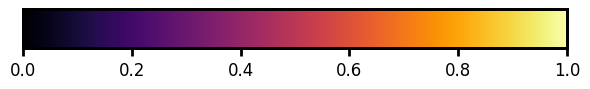

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def horizontal_color_scale(
    *,
    vmin=0.0,
    vmax=1.0,
    tick_step=0.2,
    decimals=1,
    cmap="inferno",
    figsize=(6, 1),
    border_lw=2.0,
    tick_lw=2.0,
    tick_length=6,
    label_size=12,
):
    """
    Render a horizontal color scale suitable for dense, multi-panel figures.
    """
    fig, ax = plt.subplots(figsize=figsize)

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    cbar = plt.colorbar(
        sm,
        cax=ax,
        orientation="horizontal",
    )

    ticks = np.arange(vmin, vmax + 1e-9, tick_step)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{t:.{decimals}f}" for t in ticks])

    # Tick styling
    cbar.ax.tick_params(
        axis="x",
        which="both",
        width=tick_lw,
        length=tick_length,
        labelsize=label_size,
    )

    # Explicit border via spines (robust for horizontal cax)
    for spine in cbar.ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(border_lw)

    plt.tight_layout()
    plt.show()


# example
horizontal_color_scale()


### brightness and contrast heatmaps

vizex brightness+contrast | condition=1


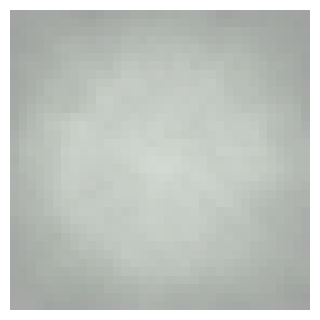

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_2.5 Hz_brightness_contrast_heatmap.png
vizex brightness+contrast | condition=2


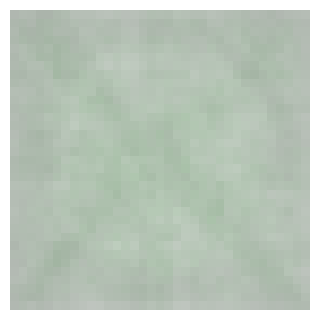

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_5 Hz_brightness_contrast_heatmap.png
vizex brightness+contrast | condition=3


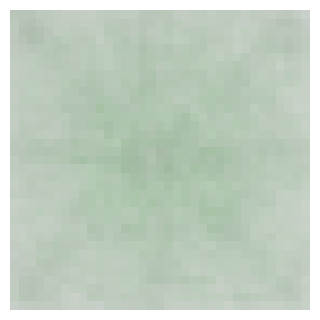

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_10 Hz_brightness_contrast_heatmap.png
vizex brightness+contrast | condition=4


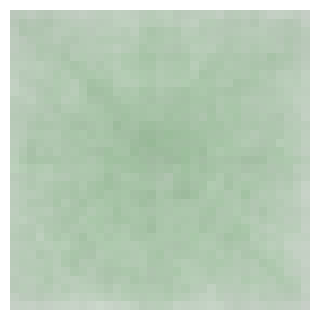

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_15 Hz_brightness_contrast_heatmap.png
vizex brightness+contrast | condition=5


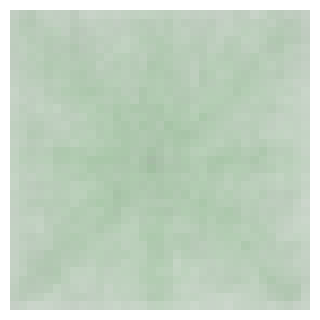

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_20 Hz_brightness_contrast_heatmap.png
vizex brightness+contrast | condition=6


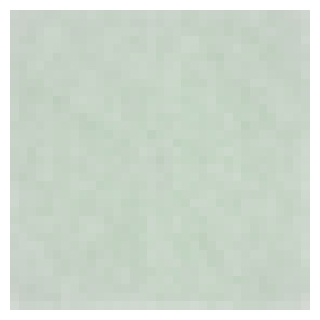

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_40 Hz_brightness_contrast_heatmap.png
vizex brightness+contrast | condition=7


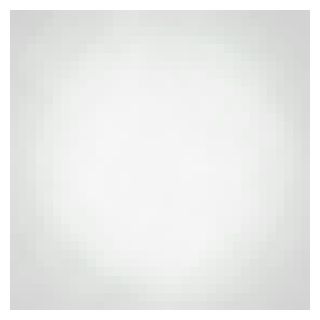

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_80 Hz_brightness_contrast_heatmap.png


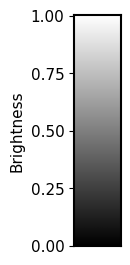

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_brightness_scale.png


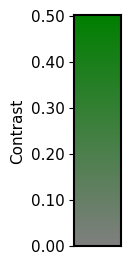

saved: E:\Research2\VizEx_analysis_replication\020_visualizations\hm_vizex_contrast_scale.png


In [103]:
# -------------------------------
# Brightness + Contrast heatmaps (interface only)
#   - Cell VALUE (V) = robust mean brightness in that bin, in [0,1]
#   - Cell SATURATION (S) = robust mean RMS-contrast in that bin, mapped 0..0.5 -> 0..1
#   - Hue fixed to green (so saturated cells are green, unsaturated are grey)
#   - Produces ONE combined heatmap per condition (brightness + contrast together)
#   - Saves two scale bars:
#       1) Brightness scale: grey bar 0..1
#       2) Contrast scale: at V=0.5, S from 0..1 corresponds to contrast 0..0.5
# -------------------------------

def _hsv_to_rgb_img(H: float, S: np.ndarray, V: np.ndarray) -> np.ndarray:
    """
    H in [0,1], S and V are arrays of shape (n,n) in [0,1]
    returns RGB (n,n,3)
    """
    import colorsys
    n, m = S.shape
    out = np.zeros((n, m, 3), dtype=np.float32)
    for i in range(n):
        for j in range(m):
            rr, gg, bb = colorsys.hsv_to_rgb(H, float(S[i, j]), float(V[i, j]))
            out[i, j] = (rr, gg, bb)
    return out


def robust_binned_brightness_and_contrast_for_group(
    df_group: pd.DataFrame,
    *,
    dataset_key: str,
    datasets: dict,
    n_bins: int = N_BINS,
) -> tuple[np.ndarray, np.ndarray]:
    """
    For each image:
      - load
      - preprocess intensity (no per-image minmax normalization; keeps absolute brightness)
      - cut into bins
      - compute per-bin:
          brightness = mean(I)
          contrast   = RMS = sqrt(mean((I - mean(I))^2))
    Then robust-reduce across images for each bin separately.
    Returns:
      (brightness_hm, contrast_hm) each shape (n_bins, n_bins)
    """
    ds = datasets[dataset_key]
    img_root = ds["image_path"]
    domain_key = ds["domain_key"]

    bright_list = []
    contr_list = []

    for _, row in df_group.iterrows():
        fname = row.get("png_filename", None)
        if not isinstance(fname, str) or not fname:
            continue
        path = os.path.join(img_root, fname)
        if not os.path.exists(path):
            continue

        img = load_grayscale_image(path)  # [0,1]
        pre = preprocess_image(img, domain_key=domain_key, preprocess_kind="intensity")

        h, w = pre.shape
        b_out = np.full((n_bins, n_bins), np.nan, dtype=np.float32)
        c_out = np.full((n_bins, n_bins), np.nan, dtype=np.float32)

        for i in range(n_bins):
            y0 = int(i * h / n_bins)
            y1 = int((i + 1) * h / n_bins)
            for j in range(n_bins):
                x0 = int(j * w / n_bins)
                x1 = int((j + 1) * w / n_bins)

                patch = pre[y0:y1, x0:x1]
                vals = patch[np.isfinite(patch)]
                if vals.size == 0:
                    continue

                mu = float(vals.mean())
                rms = float(np.sqrt(np.mean((vals - mu) ** 2)))

                b_out[i, j] = mu
                c_out[i, j] = rms

        bright_list.append(b_out)
        contr_list.append(c_out)

    if len(bright_list) == 0:
        nan_hm = np.full((n_bins, n_bins), np.nan, dtype=np.float32)
        return nan_hm, nan_hm

    b_stack = np.stack(bright_list, axis=0)
    c_stack = np.stack(contr_list, axis=0)

    b_hm = _robust_reduce(b_stack).astype(np.float32, copy=False)
    c_hm = _robust_reduce(c_stack).astype(np.float32, copy=False)

    return b_hm, c_hm


def make_brightness_scale_bar(
    *,
    save_path: str,
    text_size: int = 11,
    tick_step: float = 0.25,
):
    """
    Brightness scale: grayscale 0..1 (top=1).
    """
    vmin, vmax = 0.0, 1.0
    n = 256
    grad = np.linspace(vmax, vmin, n).reshape(n, 1)

    fig, ax = plt.subplots(figsize=SCALE_FIGSIZE)
    ax.imshow(grad, aspect="auto", cmap="gray", origin="upper", vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_ylabel("Brightness", fontsize=text_size)

    ticks = np.arange(vmin, vmax + 1e-9, tick_step)
    y_pos = 255 - ((ticks - vmin) / (vmax - vmin) * 255)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{t:.2f}" for t in ticks], fontsize=text_size)

    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

    plt.show()
    _save_tight(fig, save_path, pad=0.05)
    plt.close(fig)
    print(f"saved: {save_path}")


def make_contrast_scale_bar(
    *,
    vmax_contrast: float = 0.5,
    mid_brightness: float = 0.5,
    save_path: str,
    text_size: int = 11,
    tick_step: float = 0.10,
):
    """
    Contrast scale: at fixed V=mid_brightness, S encodes contrast 0..vmax_contrast.
      - bottom: S=0 (grey)
      - top:    S=1 (fully saturated green)
    """
    import colorsys

    vmax_contrast = float(vmax_contrast)
    n = 256

    # Saturation from 1 at top to 0 at bottom for origin='upper'
    S = np.linspace(1.0, 0.0, n).reshape(n, 1)
    V = np.full_like(S, float(mid_brightness), dtype=np.float32)

    # build RGB column
    rgb = np.zeros((n, 1, 3), dtype=np.float32)
    H = 1.0 / 3.0  # green
    for i in range(n):
        rr, gg, bb = colorsys.hsv_to_rgb(H, float(S[i, 0]), float(V[i, 0]))
        rgb[i, 0] = (rr, gg, bb)

    fig, ax = plt.subplots(figsize=SCALE_FIGSIZE)
    ax.imshow(rgb, aspect="auto", origin="upper")
    ax.set_xticks([])
    ax.set_ylabel("Contrast", fontsize=text_size)

    # ticks in contrast units
    ticks = np.arange(0.0, vmax_contrast + 1e-9, tick_step)
    ticks = np.clip(ticks, 0.0, vmax_contrast)

    # map contrast -> saturation (0..1), then to y pixel positions
    sat = ticks / vmax_contrast
    y_pos = (1.0 - sat) * (n - 1)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{t:.2f}" for t in ticks], fontsize=text_size)

    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

    plt.show()
    _save_tight(fig, save_path, pad=0.05)
    plt.close(fig)
    print(f"saved: {save_path}")


def brightness_contrast_heatmaps_interface(
    *,
    dataset_key: str = "vizex",
    datasets: dict,
    n_bins: int = N_BINS,
    save_prefix: str = "hm",
    vmax_contrast: float = 0.5,
):
    """
    Combined heatmap where:
      - V (brightness) comes from robust per-bin brightness mean in [0,1]
      - S (contrast) comes from robust per-bin RMS contrast mapped 0..vmax_contrast -> 0..1
      - Hue is green
    """
    ds = datasets[dataset_key]
    df = ds["df"]
    conds = _get_condition_values(df, "condition_code")

    saved_paths = []

    for cond in conds:
        df_g = df[df["condition_code"].astype(str) == str(cond)]
        if df_g.empty:
            continue

        b_hm, c_hm = robust_binned_brightness_and_contrast_for_group(
            df_g, dataset_key=dataset_key, datasets=datasets, n_bins=n_bins
        )

        # V = brightness (clip to [0,1] only for HSV validity; brightness is inherently [0,1])
        V = np.clip(b_hm, 0.0, 1.0)

        # S = contrast mapped by vmax_contrast
        S = np.clip(c_hm / float(vmax_contrast), 0.0, 1.0)

        rgb = _hsv_to_rgb_img(H=1.0/3.0, S=S, V=V)

        print(f"{dataset_key} brightness+contrast | condition={cond}")
        save_name = f"{save_prefix}_{dataset_key}_{_safe_label(cond)}_brightness_contrast_heatmap.png"
        save_path = os.path.join(viz_path, save_name)
        render_and_save_rgb_heatmap(rgb, save_path=save_path, figsize=HEATMAP_FIGSIZE)
        saved_paths.append(save_path)

    # Scale bars
    brightness_scale_path = os.path.join(viz_path, f"{save_prefix}_{dataset_key}_brightness_scale.png")
    contrast_scale_path   = os.path.join(viz_path, f"{save_prefix}_{dataset_key}_contrast_scale.png")

    make_brightness_scale_bar(save_path=brightness_scale_path)
    make_contrast_scale_bar(vmax_contrast=vmax_contrast, mid_brightness=0.5, save_path=contrast_scale_path)

    return saved_paths, brightness_scale_path, contrast_scale_path


# --- run ---
iface_bc_paths, iface_brightness_scale, iface_contrast_scale = brightness_contrast_heatmaps_interface(
    datasets=datasets,
    save_prefix="hm",
    vmax_contrast=0.5,
)


interface brightness+contrast | condition=1


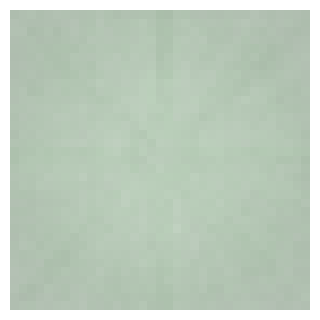

saved: E:\Research2\PSYCHEMORPH_JAVASCRIPT\data_analysis\020_visualizations\hm_interface_11Hz_brightness_contrast_heatmap.png
interface brightness+contrast | condition=4


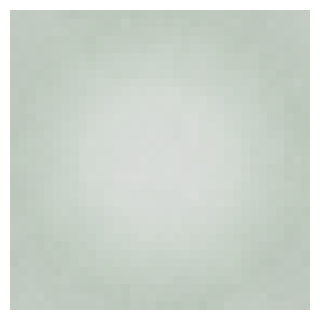

saved: E:\Research2\PSYCHEMORPH_JAVASCRIPT\data_analysis\020_visualizations\hm_interface_40Hz_brightness_contrast_heatmap.png
interface brightness+contrast | condition=8


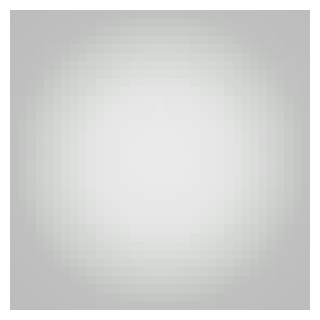

saved: E:\Research2\PSYCHEMORPH_JAVASCRIPT\data_analysis\020_visualizations\hm_interface_80Hz_brightness_contrast_heatmap.png


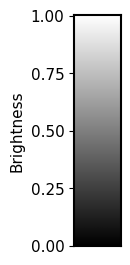

saved: E:\Research2\PSYCHEMORPH_JAVASCRIPT\data_analysis\020_visualizations\hm_interface_brightness_scale.png


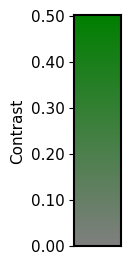

saved: E:\Research2\PSYCHEMORPH_JAVASCRIPT\data_analysis\020_visualizations\hm_interface_contrast_scale.png


In [ ]:
# -------------------------------
# Brightness + Contrast heatmaps (interface only)
#   - Cell VALUE (V) = robust mean brightness in that bin, in [0,1]
#   - Cell SATURATION (S) = robust mean RMS-contrast in that bin, mapped 0..0.5 -> 0..1
#   - Hue fixed to green (so saturated cells are green, unsaturated are grey)
#   - Produces ONE combined heatmap per condition (brightness + contrast together)
#   - Saves two scale bars:
#       1) Brightness scale: grey bar 0..1
#       2) Contrast scale: at V=0.5, S from 0..1 corresponds to contrast 0..0.5
# -------------------------------

def _hsv_to_rgb_img(H: float, S: np.ndarray, V: np.ndarray) -> np.ndarray:
    """
    H in [0,1], S and V are arrays of shape (n,n) in [0,1]
    returns RGB (n,n,3)
    """
    import colorsys
    n, m = S.shape
    out = np.zeros((n, m, 3), dtype=np.float32)
    for i in range(n):
        for j in range(m):
            rr, gg, bb = colorsys.hsv_to_rgb(H, float(S[i, j]), float(V[i, j]))
            out[i, j] = (rr, gg, bb)
    return out


def robust_binned_brightness_and_contrast_for_group(
    df_group: pd.DataFrame,
    *,
    dataset_key: str,
    datasets: dict,
    n_bins: int = N_BINS,
) -> tuple[np.ndarray, np.ndarray]:
    """
    For each image:
      - load
      - preprocess intensity (no per-image minmax normalization; keeps absolute brightness)
      - cut into bins
      - compute per-bin:
          brightness = mean(I)
          contrast   = RMS = sqrt(mean((I - mean(I))^2))
    Then robust-reduce across images for each bin separately.
    Returns:
      (brightness_hm, contrast_hm) each shape (n_bins, n_bins)
    """
    ds = datasets[dataset_key]
    img_root = ds["image_path"]
    domain_key = ds["domain_key"]

    bright_list = []
    contr_list = []

    for _, row in df_group.iterrows():
        fname = row.get("png_filename", None)
        if not isinstance(fname, str) or not fname:
            continue
        path = os.path.join(img_root, fname)
        if not os.path.exists(path):
            continue

        img = load_grayscale_image(path)  # [0,1]
        pre = preprocess_image(img, domain_key=domain_key, preprocess_kind="intensity")

        h, w = pre.shape
        b_out = np.full((n_bins, n_bins), np.nan, dtype=np.float32)
        c_out = np.full((n_bins, n_bins), np.nan, dtype=np.float32)

        for i in range(n_bins):
            y0 = int(i * h / n_bins)
            y1 = int((i + 1) * h / n_bins)
            for j in range(n_bins):
                x0 = int(j * w / n_bins)
                x1 = int((j + 1) * w / n_bins)

                patch = pre[y0:y1, x0:x1]
                vals = patch[np.isfinite(patch)]
                if vals.size == 0:
                    continue

                mu = float(vals.mean())
                rms = float(np.sqrt(np.mean((vals - mu) ** 2)))

                b_out[i, j] = mu
                c_out[i, j] = rms

        bright_list.append(b_out)
        contr_list.append(c_out)

    if len(bright_list) == 0:
        nan_hm = np.full((n_bins, n_bins), np.nan, dtype=np.float32)
        return nan_hm, nan_hm

    b_stack = np.stack(bright_list, axis=0)
    c_stack = np.stack(contr_list, axis=0)

    b_hm = _robust_reduce(b_stack).astype(np.float32, copy=False)
    c_hm = _robust_reduce(c_stack).astype(np.float32, copy=False)

    return b_hm, c_hm


def make_brightness_scale_bar(
    *,
    save_path: str,
    text_size: int = 11,
    tick_step: float = 0.25,
):
    """
    Brightness scale: grayscale 0..1 (top=1).
    """
    vmin, vmax = 0.0, 1.0
    n = 256
    grad = np.linspace(vmax, vmin, n).reshape(n, 1)

    fig, ax = plt.subplots(figsize=SCALE_FIGSIZE)
    ax.imshow(grad, aspect="auto", cmap="gray", origin="upper", vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_ylabel("Brightness", fontsize=text_size)

    ticks = np.arange(vmin, vmax + 1e-9, tick_step)
    y_pos = 255 - ((ticks - vmin) / (vmax - vmin) * 255)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{t:.2f}" for t in ticks], fontsize=text_size)

    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

    plt.show()
    _save_tight(fig, save_path, pad=0.05)
    plt.close(fig)
    print(f"saved: {save_path}")


def make_contrast_scale_bar(
    *,
    vmax_contrast: float = 0.5,
    mid_brightness: float = 0.5,
    save_path: str,
    text_size: int = 11,
    tick_step: float = 0.10,
):
    """
    Contrast scale: at fixed V=mid_brightness, S encodes contrast 0..vmax_contrast.
      - bottom: S=0 (grey)
      - top:    S=1 (fully saturated green)
    """
    import colorsys

    vmax_contrast = float(vmax_contrast)
    n = 256

    # Saturation from 1 at top to 0 at bottom for origin='upper'
    S = np.linspace(1.0, 0.0, n).reshape(n, 1)
    V = np.full_like(S, float(mid_brightness), dtype=np.float32)

    # build RGB column
    rgb = np.zeros((n, 1, 3), dtype=np.float32)
    H = 1.0 / 3.0  # green
    for i in range(n):
        rr, gg, bb = colorsys.hsv_to_rgb(H, float(S[i, 0]), float(V[i, 0]))
        rgb[i, 0] = (rr, gg, bb)

    fig, ax = plt.subplots(figsize=SCALE_FIGSIZE)
    ax.imshow(rgb, aspect="auto", origin="upper")
    ax.set_xticks([])
    ax.set_ylabel("Contrast", fontsize=text_size)

    # ticks in contrast units
    ticks = np.arange(0.0, vmax_contrast + 1e-9, tick_step)
    ticks = np.clip(ticks, 0.0, vmax_contrast)

    # map contrast -> saturation (0..1), then to y pixel positions
    sat = ticks / vmax_contrast
    y_pos = (1.0 - sat) * (n - 1)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{t:.2f}" for t in ticks], fontsize=text_size)

    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

    plt.show()
    _save_tight(fig, save_path, pad=0.05)
    plt.close(fig)
    print(f"saved: {save_path}")


def brightness_contrast_heatmaps_interface(
    *,
    dataset_key: str = "interface",
    datasets: dict,
    n_bins: int = N_BINS,
    save_prefix: str = "hm",
    vmax_contrast: float = 0.5,
):
    """
    Combined heatmap where:
      - V (brightness) comes from robust per-bin brightness mean in [0,1]
      - S (contrast) comes from robust per-bin RMS contrast mapped 0..vmax_contrast -> 0..1
      - Hue is green
    """
    ds = datasets[dataset_key]
    df = ds["df"]
    conds = _get_condition_values(df, "condition_code")

    saved_paths = []

    for cond in conds:
        df_g = df[df["condition_code"].astype(str) == str(cond)]
        if df_g.empty:
            continue

        b_hm, c_hm = robust_binned_brightness_and_contrast_for_group(
            df_g, dataset_key=dataset_key, datasets=datasets, n_bins=n_bins
        )

        # V = brightness (clip to [0,1] only for HSV validity; brightness is inherently [0,1])
        V = np.clip(b_hm, 0.0, 1.0)

        # S = contrast mapped by vmax_contrast
        S = np.clip(c_hm / float(vmax_contrast), 0.0, 1.0)

        rgb = _hsv_to_rgb_img(H=1.0/3.0, S=S, V=V)

        print(f"{dataset_key} brightness+contrast | condition={cond}")
        save_name = f"{save_prefix}_{dataset_key}_{_safe_label(cond)}_brightness_contrast_heatmap.png"
        save_path = os.path.join(viz_path, save_name)
        render_and_save_rgb_heatmap(rgb, save_path=save_path, figsize=HEATMAP_FIGSIZE)
        saved_paths.append(save_path)

    # Scale bars
    brightness_scale_path = os.path.join(viz_path, f"{save_prefix}_{dataset_key}_brightness_scale.png")
    contrast_scale_path   = os.path.join(viz_path, f"{save_prefix}_{dataset_key}_contrast_scale.png")

    make_brightness_scale_bar(save_path=brightness_scale_path)
    make_contrast_scale_bar(vmax_contrast=vmax_contrast, mid_brightness=0.5, save_path=contrast_scale_path)

    return saved_paths, brightness_scale_path, contrast_scale_path


# --- run ---
iface_bc_paths, iface_brightness_scale, iface_contrast_scale = brightness_contrast_heatmaps_interface(
    datasets=datasets,
    save_prefix="hm",
    vmax_contrast=0.5,
)


interface brightness+contrast (autoscaled) | condition=1 | B:[0.7369,0.9217] C:[4.609e-05,0.05515] scale_over=dataset


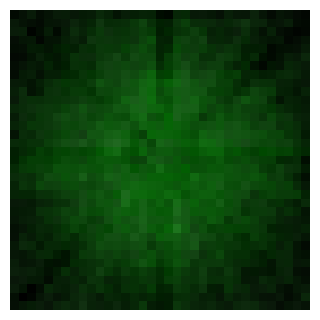

saved: E:\Research2\PSYCHEMORPH_JAVASCRIPT\data_analysis\020_visualizations\hm_interface_11Hz_brightness_contrast_heatmap_AUTOSCALED.png
interface brightness+contrast (autoscaled) | condition=4 | B:[0.7369,0.9217] C:[4.609e-05,0.05515] scale_over=dataset


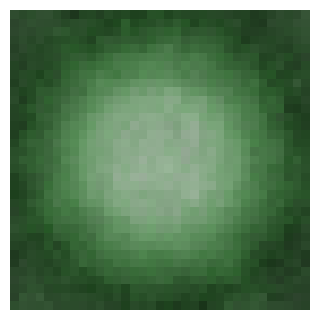

saved: E:\Research2\PSYCHEMORPH_JAVASCRIPT\data_analysis\020_visualizations\hm_interface_40Hz_brightness_contrast_heatmap_AUTOSCALED.png
interface brightness+contrast (autoscaled) | condition=8 | B:[0.7369,0.9217] C:[4.609e-05,0.05515] scale_over=dataset


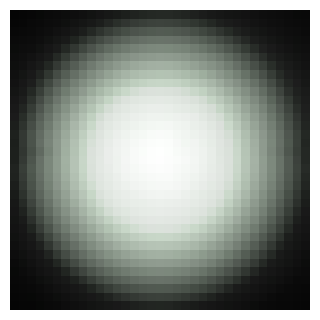

saved: E:\Research2\PSYCHEMORPH_JAVASCRIPT\data_analysis\020_visualizations\hm_interface_80Hz_brightness_contrast_heatmap_AUTOSCALED.png


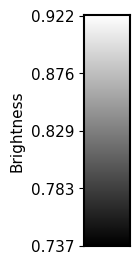

saved: E:\Research2\PSYCHEMORPH_JAVASCRIPT\data_analysis\020_visualizations\hm_interface_brightness_scale_AUTOSCALED.png


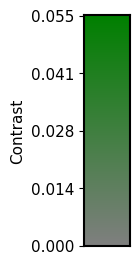

saved: E:\Research2\PSYCHEMORPH_JAVASCRIPT\data_analysis\020_visualizations\hm_interface_contrast_scale_AUTOSCALED.png


In [ ]:
# -------------------------------
# Brightness + Contrast heatmaps (AUTO-SCALED ALTERNATIVE VIEW)
#   - Brightness (V) is linearly mapped using the min/max present in the DATA
#       darkest cell -> V=0 (black), brightest cell -> V=1 (white)
#   - Contrast (S) is linearly mapped using the min/max present in the DATA
#       lowest-contrast cell -> S=0 (grey), highest-contrast cell -> S=1 (green)
#   - Hue fixed to green (so saturation is "contrast")
#   - Scale bars reflect DATA min/max (not fixed 0..1 or 0..0.5)
# -------------------------------

def _finite_minmax(arr: np.ndarray) -> tuple[float, float]:
    a = np.asarray(arr, dtype=np.float64)
    a = a[np.isfinite(a)]
    if a.size == 0:
        return (np.nan, np.nan)
    return (float(a.min()), float(a.max()))


def _linmap_to_01(x: np.ndarray, vmin: float, vmax: float) -> np.ndarray:
    x = np.asarray(x, dtype=np.float32)
    if not (np.isfinite(vmin) and np.isfinite(vmax)) or (vmax <= vmin):
        # degenerate or missing -> return zeros (valid HSV), preserving NaNs as 0
        out = np.zeros_like(x, dtype=np.float32)
        out[~np.isfinite(x)] = 0.0
        return out
    y = (x - float(vmin)) / float(vmax - vmin)
    y = np.clip(y, 0.0, 1.0)
    y[~np.isfinite(x)] = 0.0
    return y.astype(np.float32, copy=False)


def make_brightness_scale_bar_data(
    *,
    vmin_brightness: float,
    vmax_brightness: float,
    save_path: str,
    text_size: int = 11,
    n_ticks: int = 5,
):
    """
    Brightness scale: grayscale with labels in DATA units [vmin_brightness..vmax_brightness]
    (top=vmax, bottom=vmin).
    """
    vmin = float(vmin_brightness)
    vmax = float(vmax_brightness)
    n = 256

    # still render 0..1 gradient, but label it in data-units
    grad = np.linspace(1.0, 0.0, n).reshape(n, 1)

    fig, ax = plt.subplots(figsize=SCALE_FIGSIZE)
    ax.imshow(grad, aspect="auto", cmap="gray", origin="upper", vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_ylabel("Brightness", fontsize=text_size)

    if np.isfinite(vmin) and np.isfinite(vmax) and (vmax > vmin) and int(n_ticks) >= 2:
        ticks = np.linspace(vmin, vmax, int(n_ticks))
        # map data tick -> y position (top=vmax -> y=0)
        frac = (ticks - vmin) / (vmax - vmin)
        y_pos = (1.0 - frac) * (n - 1)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([f"{t:.3f}" for t in ticks], fontsize=text_size)
    else:
        ax.set_yticks([0, n - 1])
        ax.set_yticklabels([f"{vmax:.3f}", f"{vmin:.3f}"], fontsize=text_size)

    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

    plt.show()
    _save_tight(fig, save_path, pad=0.05)
    plt.close(fig)
    print(f"saved: {save_path}")


def make_contrast_scale_bar_data(
    *,
    vmin_contrast: float,
    vmax_contrast: float,
    mid_brightness: float = 0.5,
    save_path: str,
    text_size: int = 11,
    n_ticks: int = 5,
):
    """
    Contrast scale: at fixed V=mid_brightness, S encodes contrast in DATA units
      vmin_contrast -> S=0 (grey)
      vmax_contrast -> S=1 (fully saturated green)
    """
    import colorsys

    vmin = float(vmin_contrast)
    vmax = float(vmax_contrast)
    n = 256

    # Saturation from 1 at top to 0 at bottom for origin='upper'
    S = np.linspace(1.0, 0.0, n).reshape(n, 1).astype(np.float32)
    V = np.full_like(S, float(mid_brightness), dtype=np.float32)

    rgb = np.zeros((n, 1, 3), dtype=np.float32)
    H = 1.0 / 3.0  # green
    for i in range(n):
        rr, gg, bb = colorsys.hsv_to_rgb(H, float(S[i, 0]), float(V[i, 0]))
        rgb[i, 0] = (rr, gg, bb)

    fig, ax = plt.subplots(figsize=SCALE_FIGSIZE)
    ax.imshow(rgb, aspect="auto", origin="upper")
    ax.set_xticks([])
    ax.set_ylabel("Contrast", fontsize=text_size)

    if np.isfinite(vmin) and np.isfinite(vmax) and (vmax > vmin) and int(n_ticks) >= 2:
        ticks = np.linspace(vmin, vmax, int(n_ticks))
        # map contrast -> saturation (0..1), then to y pixel positions
        sat = (ticks - vmin) / (vmax - vmin)
        sat = np.clip(sat, 0.0, 1.0)
        y_pos = (1.0 - sat) * (n - 1)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([f"{t:.3f}" for t in ticks], fontsize=text_size)
    else:
        ax.set_yticks([0, n - 1])
        ax.set_yticklabels([f"{vmax:.3f}", f"{vmin:.3f}"], fontsize=text_size)

    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

    plt.show()
    _save_tight(fig, save_path, pad=0.05)
    plt.close(fig)
    print(f"saved: {save_path}")


def brightness_contrast_heatmaps_interface_autoscaled(
    *,
    dataset_key: str = "interface",
    datasets: dict,
    n_bins: int = N_BINS,
    save_prefix: str = "hm",
    scale_over: str = "dataset",  # "dataset" (shared across conditions) or "condition"
):
    """
    Alternative view: V and S are both linearly mapped using min/max present in the data.

    scale_over:
      - "dataset": find global min/max across all conditions (recommended for comparability)
      - "condition": scale each condition independently (max contrast per-cond)
    """
    ds = datasets[dataset_key]
    df = ds["df"]
    conds = _get_condition_values(df, "condition_code")

    # ---- first pass: compute heatmaps for all conditions ----
    hm_by_cond = {}
    for cond in conds:
        df_g = df[df["condition_code"].astype(str) == str(cond)]
        if df_g.empty:
            continue
        b_hm, c_hm = robust_binned_brightness_and_contrast_for_group(
            df_g, dataset_key=dataset_key, datasets=datasets, n_bins=n_bins
        )
        hm_by_cond[cond] = (b_hm, c_hm)

    if len(hm_by_cond) == 0:
        return [], None, None

    # ---- scaling bounds ----
    if str(scale_over).lower() == "dataset":
        b_all = np.stack([v[0] for v in hm_by_cond.values()], axis=0)
        c_all = np.stack([v[1] for v in hm_by_cond.values()], axis=0)
        b_min, b_max = _finite_minmax(b_all)
        c_min, c_max = _finite_minmax(c_all)

    saved_paths = []

    # ---- render per condition ----
    for cond, (b_hm, c_hm) in hm_by_cond.items():
        if str(scale_over).lower() == "condition":
            b_min, b_max = _finite_minmax(b_hm)
            c_min, c_max = _finite_minmax(c_hm)

        # map to HSV domain [0,1]
        V = _linmap_to_01(b_hm, b_min, b_max)  # brightness -> value
        S = _linmap_to_01(c_hm, c_min, c_max)  # contrast   -> saturation

        rgb = _hsv_to_rgb_img(H=1.0 / 3.0, S=S, V=V)

        print(
            f"{dataset_key} brightness+contrast (autoscaled) | condition={cond} "
            f"| B:[{b_min:.4g},{b_max:.4g}] C:[{c_min:.4g},{c_max:.4g}] scale_over={scale_over}"
        )
        save_name = (
            f"{save_prefix}_{dataset_key}_{_safe_label(cond)}_brightness_contrast_heatmap_AUTOSCALED.png"
        )
        save_path = os.path.join(viz_path, save_name)
        render_and_save_rgb_heatmap(rgb, save_path=save_path, figsize=HEATMAP_FIGSIZE)
        saved_paths.append(save_path)

    # ---- scale bars (use dataset-level bounds if scale_over="dataset"; else reflect last cond) ----
    # For "condition", these bars aren’t strictly meaningful across conditions; still useful as a reference.
    brightness_scale_path = os.path.join(
        viz_path, f"{save_prefix}_{dataset_key}_brightness_scale_AUTOSCALED.png"
    )
    contrast_scale_path = os.path.join(
        viz_path, f"{save_prefix}_{dataset_key}_contrast_scale_AUTOSCALED.png"
    )

    make_brightness_scale_bar_data(
        vmin_brightness=b_min, vmax_brightness=b_max, save_path=brightness_scale_path
    )
    make_contrast_scale_bar_data(
        vmin_contrast=c_min, vmax_contrast=c_max, mid_brightness=0.5, save_path=contrast_scale_path
    )

    return saved_paths, brightness_scale_path, contrast_scale_path


# --- run (autoscaled alternative view) ---
iface_bc_paths_auto, iface_brightness_scale_auto, iface_contrast_scale_auto = (
    brightness_contrast_heatmaps_interface_autoscaled(
        datasets=datasets,
        save_prefix="hm",
        scale_over="dataset",  # or "condition"
    )
)
